In [251]:
#by Willkie
import os
import warnings
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import pandas as pd
import re
from datetime import datetime
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LinearRegression
import numpy as np
warnings.filterwarnings('ignore')
%matplotlib inline
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
#https://discord.com/channels/1134059900666916935/1283610000484208670

In [307]:
# Ensure the output folder exists
os.makedirs(output_folder, exist_ok=True)

# Define input and output folders
input_folder = "data/txt"
output_folder = "data/output"
file_paths = [os.path.join(input_folder, file) for file in os.listdir(input_folder) if file.endswith(".txt")]

# Job dictionary and spec ranges
job_dict = {
    "허": "허밋", "시프": "시프", "썬": "썬콜", "불독": "불독",
    "프": "프리스트", "레": "레인저", "저": "저격수",
    "용": "용기사", "크": "크루세이더", "나": "나이트"
}
job_spec_ranges = {
    "용": (3000, 9000), "크": (2000, 9000), "나": (2000, 9000),
    "허": (1500, 4000), "시프": (1500, 5000), "썬": (500, 1200),
    "불독": (500, 1200), "프": (500, 1200), "레": (2000, 9000),
    "저": (2000, 9000)
}
level_min, level_max = 80, 200

# Regex patterns
time_pattern = r"(오전|오후) \d{1,2}:\d{2}"
job_pattern = r"(\d{2,3})\s?(" + "|".join(job_dict.keys()) + r")"
spec_pattern = r"(\d{3,4})"
map_pattern = r"(망용둥|위둥|큰둥|와협|블와둥|협동|레와둥|붉켄|검켄|푸켄|불어전|물어전|오징어|깊바협|망둥쩔|듀파|듀미굴|갈림길|산양|하둥)"

In [253]:
def extract_level_and_spec(text, job_start, job_end, level_range, spec_range):
    """
    Extracts level and spec values by searching limited characters around the job.
    Level is searched from the left, and spec is searched from the right.
    """
    # Limit the search space
    left_text = text[job_start-5 : job_start+5]  # 6 characters left of the job
    right_text = text[job_end+1 : job_end + 10]  # 6 characters right of the job

    # print ("left:", left_text, "right:", right_text)
    
    level, spec = None, None

    # Search for level in the left_text
    for match in re.finditer(r"\d{2,3}", left_text[::-1]):  # Reverse for easier parsing
        num = int(match.group()[::-1])  # Reverse back the number
        if level_range[0] <= num <= level_range[1]:
            level = num
            break

    # Search for spec in the right_text
    for match in re.finditer(r"\d{3,4}", right_text):
        num = int(match.group())
        if spec_range[0] <= num <= spec_range[1]:
            spec = num
            break

    return level, spec

In [341]:
def collect_initial_data(file_path):
    columns = ["party_id", "time", "level", "job", "spec", "map", "date", "valid", "valid_spec"]
    df = pd.DataFrame(columns=columns)

    # Extract date from filename
    month = file_path[-8:-6]
    day = file_path[-6:-4]
    date_from_file = f"2024-{month}-{day}"
    
    party_id = 1
    
    with open(file_path, "r", encoding="utf-8") as file:
        data = file.read()

    blocks = data.split("오늘")
    for block in blocks[1:]:
        time_match = re.search(time_pattern, block)
        time = time_match.group(0) if time_match else None
        map_match = re.search(map_pattern, block)
        map_name = map_match.group(0) if map_match else None

        job_matches = list(re.finditer(job_pattern, block))
        for job_match in job_matches:
            job_short = job_match.group(2)
            job_full = job_dict.get(job_short, "Unknown")

            level, spec = extract_level_and_spec(
                block, job_match.start(), job_match.end(),
                (level_min, level_max), job_spec_ranges.get(job_short, (None, None))
            )
            
            valid = map_name is not None and job_full != "Unknown"

            # print(level, job_full, spec)
            
            # Append new row to DataFrame
            df = pd.concat([
                df,
                pd.DataFrame([{
                    "party_id": party_id,
                    "time": time,
                    "level": level,
                    "job": job_full,
                    "spec": spec,
                    "map": map_name,
                    "date": date_from_file,
                    "valid": valid,
                    "valid_spec": None
                }])
            ], ignore_index=True)

        party_id += 1

    # Remove duplicates
    df = df.drop_duplicates(subset=["map", "level", "job", "spec"], keep="first")

    # Add spec_by_level column
    df["spec_by_level"] = df.apply(
        lambda row: row["spec"] / row["level"] if pd.notna(row["spec"]) and pd.notna(row["level"]) else None,
        axis=1
    )
    # Calculate average spec_by_level by job
    avg_spec_by_level = df.groupby("job")["spec_by_level"].mean().rename("avg_spec_by_level")
    df = df.merge(avg_spec_by_level, on="job", how="left")
    
    # Determine spec_valid based on 20% margin
    def is_spec_valid(row):
        if pd.notna(row["spec_by_level"]) and pd.notna(row["avg_spec_by_level"]):
            lower_bound = 0.8 * row["avg_spec_by_level"]
            upper_bound = 1.2 * row["avg_spec_by_level"]
            return lower_bound <= row["spec_by_level"] <= upper_bound
        return False
    
    df["valid_spec"] = df.apply(is_spec_valid, axis=1)

    # fill na spec
    df["spec_filled"] = df["level"] * df["avg_spec_by_level"]
    df["spec_filled"] = df.apply(lambda row: row["spec"] if pd.notna(row["spec"]) else row["spec_filled"], axis=1)
    
    output_file = os.path.join(output_folder, os.path.basename(file_path).replace('.txt', '.csv'))
    df.to_csv(output_file, index=False)
    print(f"Data saved as {output_file}")
    return df

def process_data(df, file_path):
    """
    Filters and processes data to save only rows where valid and valid_spec are True.
    """
    # Filter rows where both 'valid' and 'valid_spec' are True
    processed_df = df[(df["valid"]) & (df["valid_spec"])]

    # Save the processed DataFrame to a CSV file
    processed_output_file = os.path.join(output_folder, os.path.basename(file_path).replace('.txt', '_processed.csv'))
    processed_df.to_csv(processed_output_file, index=False)

    print(f"Processed valid data saved as {processed_output_file}")
    return processed_df

In [342]:
def process_files(file_paths, output_folder):
    """
    Processes multiple text files, combines them into a single DataFrame for valid processed data,
    and saves the final output as CSV files.

    Parameters:
        file_paths (list): List of paths to the text files.
        output_folder (str): Path to the folder where CSV files will be saved.
    """
    all_raw_data = []
    all_valid_processed_data = []

    # Ensure the output folder exists
    os.makedirs(output_folder, exist_ok=True)

    for file_path in file_paths:
        # Collect initial raw data
        raw_df = collect_initial_data(file_path)

        # Process and filter valid data
        valid_processed_df = process_data(raw_df, file_path)

        all_raw_data.append(raw_df)
        all_valid_processed_data.append(valid_processed_df)

    # Combine all raw DataFrames
    combined_raw_df = pd.concat(all_raw_data, ignore_index=True)
    combined_valid_processed_df = pd.concat(all_valid_processed_data, ignore_index=True)

    # Save the combined DataFrames
    combined_raw_output = os.path.join(output_folder, "df.csv")
    combined_processed_output = os.path.join(output_folder, "processed_df.csv")

    combined_raw_df.to_csv(combined_raw_output, index=False)
    combined_valid_processed_df.to_csv(combined_processed_output, index=False)

    print(f"Combined raw data saved as '{combined_raw_output}'")
    print(f"Combined valid processed data saved as '{combined_processed_output}'")

    return combined_raw_df, combined_valid_processed_df


In [343]:
# Process files and save results
df_combined_raw, df_combined_valid_processed = process_files(file_paths, output_folder)

Data saved as data/output/1213.csv
Processed valid data saved as data/output/1213_processed.csv
Data saved as data/output/1212.csv
Processed valid data saved as data/output/1212_processed.csv
Data saved as data/output/1211.csv
Processed valid data saved as data/output/1211_processed.csv
Data saved as data/output/1215.csv
Processed valid data saved as data/output/1215_processed.csv
Data saved as data/output/1214.csv
Processed valid data saved as data/output/1214_processed.csv
Data saved as data/output/1216.csv
Processed valid data saved as data/output/1216_processed.csv
Data saved as data/output/1217.csv
Processed valid data saved as data/output/1217_processed.csv
Combined raw data saved as 'data/output/df.csv'
Combined valid processed data saved as 'data/output/processed_df.csv'


In [344]:
df = pd.read_csv("data/output/df.csv")
df

,party_id,time,level,job,spec,map,date,valid,valid_spec,spec_by_level,avg_spec_by_level,spec_filled
0,1,오후 5:42,143.0,레인저,NaN,깊바협,2024-12-13,True,False,NaN,NaN,NaN
1,1,오후 5:42,124.0,허밋,NaN,깊바협,2024-12-13,True,False,NaN,17.627570,2185.818638
2,1,오후 5:42,102.0,프리스트,NaN,깊바협,2024-12-13,True,False,NaN,6.057246,617.839130
3,2,오후 5:42,91.0,불독,NaN,듀파,2024-12-13,True,False,NaN,NaN,NaN
4,2,오후 5:42,84.0,프리스트,NaN,듀파,2024-12-13,True,False,NaN,6.057246,508.808696
...,...,...,...,...,...,...,...,...,...,...,...,...
2486,292,오후 1:59,143.0,용기사,5000.0,블와둥,2024-12-17,True,True,34.965035,35.282984,5000.000000
2487,297,오후 1:59,119.0,프리스트,NaN,검켄,2024-12-17,True,False,NaN,6.320755,752.169811
2488,297,오후 1:59,134.0,프리스트,NaN,검켄,2024-12-17,True,False,NaN,6.320755,846.981132
2489,300,오후 1:59,123.0,프리스트,NaN,NaN,2024-12-17,False,False,NaN,6.320755,777.452830


In [345]:
processed_df = pd.read_csv("data/output/processed_df.csv")
processed_df

,party_id,time,level,job,spec,map,date,valid,valid_spec,spec_by_level,avg_spec_by_level,spec_filled
0,8,오후 5:43,122,허밋,2100,협동,2024-12-13,True,True,17.213115,17.627570,2100.0
1,8,오후 5:43,149,썬콜,920,협동,2024-12-13,True,True,6.174497,6.173481,920.0
2,34,오후 5:44,140,크루세이더,4570,깊바협,2024-12-13,True,True,32.642857,32.642857,4570.0
3,45,오후 5:44,123,허밋,2160,듀파,2024-12-13,True,True,17.560976,17.627570,2160.0
4,46,오후 5:44,150,프리스트,915,큰둥,2024-12-13,True,True,6.100000,6.057246,915.0
...,...,...,...,...,...,...,...,...,...,...,...,...
281,260,오후 1:57,106,나이트,3143,듀파,2024-12-17,True,True,29.650943,30.555809,3143.0
282,260,오후 1:57,89,나이트,2800,듀파,2024-12-17,True,True,31.460674,30.555809,2800.0
283,263,오후 1:57,106,프리스트,670,불어전,2024-12-17,True,True,6.320755,6.320755,670.0
284,263,오후 1:57,107,용기사,3400,불어전,2024-12-17,True,True,31.775701,35.282984,3400.0


In [346]:
hermit = processed_df[(processed_df['job'] == '허밋')]
hermit

,party_id,time,level,job,spec,map,date,valid,valid_spec,spec_by_level,avg_spec_by_level,spec_filled
0,8,오후 5:43,122,허밋,2100,협동,2024-12-13,True,True,17.213115,17.627570,2100.0
3,45,오후 5:44,123,허밋,2160,듀파,2024-12-13,True,True,17.560976,17.627570,2160.0
5,48,오후 5:45,138,허밋,2514,망용둥,2024-12-13,True,True,18.217391,17.627570,2514.0
6,109,오후 5:45,133,허밋,2330,망용둥,2024-12-13,True,True,17.518797,17.627570,2330.0
11,5,오후 4:33,155,허밋,2900,협동,2024-12-12,True,True,18.709677,18.832931,2900.0
...,...,...,...,...,...,...,...,...,...,...,...,...
265,161,오후 1:52,140,허밋,2700,협동,2024-12-17,True,True,19.285714,18.956725,2700.0
266,161,오후 1:52,133,허밋,2400,협동,2024-12-17,True,True,18.045113,18.956725,2400.0
269,163,오후 1:52,124,허밋,2500,협동,2024-12-17,True,True,20.161290,18.956725,2500.0
272,197,오후 1:54,124,허밋,2520,협동,2024-12-17,True,True,20.322581,18.956725,2520.0


In [347]:
# Display basic information about the DataFrame
print("Basic Info:")
print(df.info())

print("\nData Overview:")
print(df.head())

# Count frequency of maps
map_counts = df["map"].value_counts()

print("\nMap Frequency:")
print(map_counts)

# Count frequency of jobs
job_counts = df["job"].value_counts()

print("\nJob Frequency:")
print(job_counts)

# Distribution of levels by job
print("\nLevel Statistics by Job:")
print(df.groupby("job")["level"].describe())

# Convert 'level' column to numeric for analysis
df["level"] = pd.to_numeric(df["level"], errors="coerce")

Basic Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2491 entries, 0 to 2490
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   party_id           2491 non-null   int64  
 1   time               2491 non-null   object 
 2   level              2459 non-null   float64
 3   job                2491 non-null   object 
 4   spec               337 non-null    float64
 5   map                2206 non-null   object 
 6   date               2491 non-null   object 
 7   valid              2491 non-null   bool   
 8   valid_spec         2491 non-null   bool   
 9   spec_by_level      337 non-null    float64
 10  avg_spec_by_level  2359 non-null   float64
 11  spec_filled        2329 non-null   float64
dtypes: bool(2), float64(5), int64(1), object(4)
memory usage: 199.6+ KB
None

Data Overview:
   party_id     time  level   job  spec  map        date  valid  valid_spec  \
0         1  오후 5:42  143.0   레인저   

In [348]:
# 1. Map Distribution
def map_dist(df):
    plt.figure(figsize=(10, 6))
    sns.countplot(y="map", data=df, order=map_counts.index, palette="viridis")
    plt.title("Frequency of Maps")
    plt.xlabel("Count")
    plt.ylabel("Map")
    plt.tight_layout()
    plt.show()

# 2. Job Distribution
def job_dist(df):
    plt.figure(figsize=(10, 6))
    sns.countplot(y="job", data=df, order=job_counts.index, palette="coolwarm")
    plt.title("Frequency of Jobs")
    plt.xlabel("Count")
    plt.ylabel("Job")
    plt.tight_layout()
    plt.show()

# 3. Level Distribution Overall
def level_dist(df):
    plt.figure(figsize=(10, 6))
    sns.histplot(df["level"], kde=True, bins=30, color="skyblue")
    plt.title("Level Distribution")
    plt.xlabel("Level")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

# 4. Level Distribution by Job
def level_dist_by_job(df):
    plt.figure(figsize=(12, 8))
    sns.boxplot(x=df["job"], y=df["level"], data=df, palette="muted")
    plt.title("Level Distribution by Job")
    plt.xlabel("Job")
    plt.ylabel("Level")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [349]:
def average_spec_by_job(df):
    # Ensure the 'spec' column is numeric, replacing non-numeric values with NaN
    df['spec'] = pd.to_numeric(df['spec'], errors='coerce')
    
    # Calculate the average spec by job, ignoring NaN values
    average_spec_by_job = df.groupby('job')['spec'].mean().reset_index()
    
    # Fill NaN values with 0 for jobs with no spec data
    average_spec_by_job['spec'] = average_spec_by_job['spec'].fillna(0)
    
    # Ensure all jobs are represented, even if they have no spec data
    all_jobs = list(job_dict.values())  # Ensure all jobs from job_dict are present
    missing_jobs = [job for job in all_jobs if job not in average_spec_by_job['job'].values]
    
    # Create a DataFrame for missing jobs with spec value set to 0
    missing_jobs_df = pd.DataFrame({'job': missing_jobs, 'spec': [0]*len(missing_jobs)})
    
    # Concatenate the missing jobs DataFrame with the existing DataFrame
    average_spec_by_job = pd.concat([average_spec_by_job, missing_jobs_df], ignore_index=True)
    
    # Sort the data for better visualization
    average_spec_by_job = average_spec_by_job.sort_values('spec', ascending=False)
    
    # Set up the visualizations
    plt.figure(figsize=(10, 6))
    sns.barplot(x='spec', y='job', data=average_spec_by_job, palette='viridis')
    
    # Add labels and title
    plt.xlabel('Average Spec')
    plt.ylabel('Job')
    plt.title('Average Spec by Job')
    
    # Display the plot
    plt.show()

In [350]:
def plot_job_frequency_by_map(df):
    # Count the number of occurrences of each job in each map
    job_map_counts = df.groupby(["map", "job"]).size().reset_index(name="count")
    
    # Create a pivot table for better visualization
    job_map_pivot = job_map_counts.pivot(index="map", columns="job", values="count").fillna(0)
    
    # Plot the heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(job_map_pivot, annot=True, fmt=".0f", cmap="YlGnBu", cbar_kws={'label': 'Job Count'})
    plt.title("Job Frequency by Map")
    plt.ylabel("Map")
    plt.xlabel("Job")
    plt.show()

In [351]:
def plot_level_spec_with_regression(df, input_job):
    """
    Plots Level vs Spec for a specific job with a linear regression line and equation.

    Parameters:
    - df: DataFrame containing the data.
    - input_job: The specific job to filter and plot (e.g., '허밋').
    """
    job_df = df[df["job"] == input_job].dropna(subset=["level", "spec"])
    
    # Check if there are enough data points for regression
    if len(job_df) < 2:
        print(f"Not enough data points to compute regression for job: {input_job}")
        return

    # Prepare data for linear regression
    X = job_df["level"].values.reshape(-1, 1)
    y = job_df["spec"].values
    
    # Fit linear regression model
    model = LinearRegression()
    model.fit(X, y)
    coef = model.coef_[0]
    intercept = model.intercept_
    
    # Regression equation
    equation = f"Spec = {coef:.2f} * Level + {intercept:.2f}"
    
    # Plot Level vs Spec
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=job_df, x="level", y="spec", s=100, label=f"{input_job} Data")
    sns.lineplot(x=job_df["level"], y=model.predict(X), color="red", label="Regression Line")
    plt.title(f"{input_job}'s Level vs Spec", fontsize=16)
    plt.suptitle(equation, fontsize=12, color="gray")
    plt.xlabel("Level", fontsize=14)
    plt.ylabel("Spec", fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()


In [352]:
def plot_level_spec_with_regression_by_level(df, input_job, level_input):
    """
    Plots Level vs Spec for a specific job and level range with a linear regression line and equation.

    Parameters:
    - df: DataFrame containing the data.
    - input_job: The specific job to filter and plot (e.g., '허밋').
    - level_input: The center level to filter by (e.g., 120).
    """
    # Filter data for the specific job and level range (±5)
    job_df = df[(df["job"] == input_job) & 
                (df["level"] >= level_input - 5) & 
                (df["level"] <= level_input + 5)].dropna(subset=["level", "spec"])

    # Check if there are enough data points for regression
    if len(job_df) < 2:
        print(f"Not enough data points to compute regression for job: {input_job} and level {level_input}")
        return

    # Prepare data for linear regression
    X = job_df["level"].values.reshape(-1, 1)
    y = job_df["spec"].values

    # Fit linear regression model
    model = LinearRegression()
    model.fit(X, y)
    coef = model.coef_[0]
    intercept = model.intercept_

    # Regression equation
    equation = f"Spec = {coef:.2f} * Level + {intercept:.2f}"

    # Plot Level vs Spec
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=job_df, x="level", y="spec", s=100, label=f"{input_job} Data")
    sns.lineplot(x=job_df["level"], y=model.predict(X), color="red", label="Regression Line")
    plt.title(f"{input_job}'s Level vs Spec (Level {level_input} ± 5)", fontsize=16)
    plt.suptitle(equation, fontsize=12, color="gray")
    plt.xlabel("Level", fontsize=14)
    plt.ylabel("Spec", fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [353]:
def plot_level_by_map_by_job(df, job):
    """
    Plots the level distribution by map for a specific job, limiting to maps with 5% or higher usage.

    Parameters:
        df (pd.DataFrame): The input DataFrame.
        job (str): The job to filter the data for.
    """
    # Filter data for the specified job
    job_df = df[df["job"] == job]

    # Calculate map usage percentages
    map_counts = job_df["map"].value_counts(normalize=True)  # Normalize=True gives percentages
    valid_maps = map_counts[map_counts >= 0.05].index  # Keep maps with 5% or more usage

    # Filter job_df to include only valid maps
    filtered_job_df = job_df[job_df["map"].isin(valid_maps)]

    if filtered_job_df.empty:
        print(f"No maps with >=5% usage for job: {job}")
        return

    # Plot the boxplot
    plt.figure(figsize=(12, 6))
    sns.boxplot(data=filtered_job_df, x="map", y="level", palette="Set2")
    plt.title(f"{job} 레벨별 맵 (5% 이상 사용된 맵)")
    plt.xlabel("Map")
    plt.ylabel("Level")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


In [354]:
def visualize_spec_validity_by_map(df, input_job='all'):
    """
    Visualizes the validity of the data by map using stacked bars.
    Filters data for a specific job if provided.

    Parameters:
        df (pd.DataFrame): The dataset containing 'map' and 'valid_spec' columns.
        input_job (str): The job to filter data by. Use 'all' to include all jobs.
    """
    # Filter for a specific job if provided
    if input_job.lower() != 'all':
        df = df[df['job'] == input_job]
        if df.empty:
            print(f"No data available for job '{input_job}'.")
            return

    # Count valid and invalid entries for each map
    spec_validity_by_map = df.groupby(['map', 'valid_spec']).size().unstack(fill_value=0)

    # Reset index for plotting
    spec_validity_by_map = spec_validity_by_map.reset_index()

    # Set up figure
    plt.figure(figsize=(12, 7))

    # Plot stacked bars
    plt.bar(spec_validity_by_map['map'], spec_validity_by_map[0], label='미기재', color='#FF6F61')
    plt.bar(spec_validity_by_map['map'], spec_validity_by_map[1], bottom=spec_validity_by_map[0], label='기재', color='#6B8E23')

    # Customize plot
    title = f"맵별 스공기재여부 ({input_job})" if input_job.lower() != 'all' else "맵별 스공기재여부"
    plt.title(title, fontsize=16)
    plt.xlabel('Map', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.legend(title='스공기재여부', fontsize=12)
    plt.tight_layout()
    plt.show()


def visualize_spec_validity_by_job(df, input_job='all'):
    """
    Visualizes the validity of the data by job using stacked bars.
    Filters data for a specific job if provided.

    Parameters:
        df (pd.DataFrame): The dataset containing 'job' and 'valid_spec' columns.
        input_job (str): The job to filter data by. Use 'all' to include all jobs.
    """
    # Filter for a specific job if provided
    if input_job.lower() != 'all':
        df = df[df['job'] == input_job]
        if df.empty:
            print(f"No data available for job '{input_job}'.")
            return

    # Count valid and invalid entries for each job
    validity_by_job = df.groupby(['job', 'valid_spec']).size().unstack(fill_value=0)

    # Reset index for plotting
    validity_by_job = validity_by_job.reset_index()

    # Set up figure
    plt.figure(figsize=(12, 7))

    # Plot stacked bars
    plt.bar(validity_by_job['job'], validity_by_job[0], label='미기재', color='#FF6F61')
    plt.bar(validity_by_job['job'], validity_by_job[1], bottom=validity_by_job[0], label='기재', color='#6B8E23')

    # Customize plot
    title = f"스공기재여부 ({input_job})" if input_job.lower() != 'all' else "직업별 스공기재여부"
    plt.title(title, fontsize=16)
    plt.xlabel('Job', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.legend(title='스공기재여부', fontsize=12)
    plt.tight_layout()
    plt.show()



def visualize_spec_validity_by_job(df):
    """
    Visualizes the validity of the data by job using stacked bars.
    """
    # Count valid and invalid entries for each job
    validity_by_job = df.groupby(['job', 'valid_spec']).size().unstack(fill_value=0)

    # Reset index for plotting
    validity_by_job = validity_by_job.reset_index()

    # Set up figure
    plt.figure(figsize=(12, 7))

    # Plot stacked bars
    plt.bar(validity_by_job['job'], validity_by_job[0], label='미기재', color='#FF6F61')
    plt.bar(validity_by_job['job'], validity_by_job[1], bottom=validity_by_job[0], label='기재', color='#6B8E23')

    # Customize plot
    plt.title('직업별 스공기재여부', fontsize=16)
    plt.xlabel('Job', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.legend(title='스공기재여부', fontsize=12)
    plt.tight_layout()
    plt.show()

In [355]:
def visualize_map_distribution_by_date(df):
    """
    Visualizes map distribution by date as a stacked bar chart with diverse colors.
    """
    # Count occurrences of maps by date
    map_counts = df.groupby(['date', 'map']).size().unstack(fill_value=0)

    # Generate a colormap with as many distinct colors as maps
    num_maps = map_counts.shape[1]
    colormap = cm.get_cmap('tab20', num_maps)  # Use 'tab20' or any other diverse colormap
    colors = [mcolors.to_hex(colormap(i)) for i in range(num_maps)]

    # Plot stacked bar chart
    map_counts.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors)
    plt.title('Map Distribution by Date', fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Count', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.legend(title='Map', fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [356]:
def visualize_level_spec_comparison(df, jobs):
    """
    Visualizes the relationship between level and spec for selected jobs.

    Parameters:
    - df: DataFrame containing the data.
    - jobs: List of jobs to include in the comparison.
    """
    # Filter data for the selected jobs
    job_data = df[df['job'].isin(jobs)].copy()

    # Ensure level and spec are numeric
    job_data['level'] = pd.to_numeric(job_data['level'], errors='coerce')
    job_data['spec'] = pd.to_numeric(job_data['spec'], errors='coerce')

    # Drop rows with missing or invalid level/spec values
    job_data = job_data.dropna(subset=['level', 'spec'])

    # Dynamically generate colors for the jobs
    color_palette = sns.color_palette("husl", len(jobs))
    colors = {job: color for job, color in zip(jobs, color_palette)}

    plt.figure(figsize=(12, 8))

    # Scatter plot with hue for different jobs
    sns.scatterplot(data=job_data, x='level', y='spec', hue='job', style='job', s=100, alpha=0.6, palette=colors)

    # Add regression lines for each job
    for job in jobs:
        job_specific_data = job_data[job_data['job'] == job]
        if not job_specific_data.empty:
            x = job_specific_data['level'].values.reshape(-1, 1)
            y = job_specific_data['spec'].values
            if len(x) > 1:  # Ensure there are enough points for regression
                model = LinearRegression()
                model.fit(x, y)
                coef = model.coef_[0]
                intercept = model.intercept_
                sns.lineplot(x=job_specific_data['level'], y=model.predict(x), color=colors[job], label=f'{job} Trend')
                # Add regression equation as text
                plt.text(
                    0.05, 0.9 - jobs.index(job) * 0.1,
                    f'{job}: Spec = {coef:.2f} * Level + {intercept:.2f}',
                    transform=plt.gca().transAxes,
                    fontsize=12,
                    bbox=dict(facecolor='white', alpha=0.7)
                )

    # Customize plot appearance
    plt.title('Level vs. Spec Comparison for Selected Jobs', fontsize=16)
    plt.xlabel('Level', fontsize=14)
    plt.ylabel('Spec', fontsize=14)
    plt.legend(title='Job', fontsize=12, loc='lower right')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

In [357]:
def plot_level_spec_with_regression_by_level(df, input_job, level_input):
    """
    Plots Level vs Spec for a specific job and level range with a linear regression line and equation.

    Parameters:
    - df: DataFrame containing the data.
    - input_job: The specific job to filter and plot (e.g., '허밋').
    - level_input: The center level to filter by (e.g., 120).
    """
    # Filter data for the specific job and level range (±5)
    job_df = df[(df["job"] == input_job) & 
                (df["level"] >= level_input - 5) & 
                (df["level"] <= level_input + 5)].dropna(subset=["level", "spec"])

    # Check if there are enough data points for regression
    if len(job_df) < 2:
        print(f"Not enough data points to compute regression for job: {input_job} and level {level_input}")
        return

    # Prepare data for linear regression
    X = job_df["level"].values.reshape(-1, 1)
    y = job_df["spec"].values

    # Fit linear regression model
    model = LinearRegression()
    model.fit(X, y)
    coef = model.coef_[0]
    intercept = model.intercept_

    # Regression equation
    equation = f"Spec = {coef:.2f} * Level + {intercept:.2f}"

    # Plot Level vs Spec
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=job_df, x="level", y="spec", s=100, label=f"{input_job} Data")
    sns.lineplot(x=job_df["level"], y=model.predict(X), color="red", label="Regression Line")
    plt.title(f"{input_job}'s Level vs Spec (Level {level_input} ± 5)", fontsize=16)
    plt.suptitle(equation, fontsize=12, color="gray")
    plt.xlabel("Level", fontsize=14)
    plt.ylabel("Spec", fontsize=14)
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()


In [358]:
def plot_combined_scatter_with_regression(df, level_threshold):
    """
    Filters data by level threshold and plots a scatterplot for map, level, and spec
    with regression lines per job and map as the marker style.

    Parameters:
        df (pd.DataFrame): The DataFrame containing the data.
        level_threshold (int): The minimum level to filter by.
    """
    # Filter the DataFrame
    filtered_df = df[df["level"] >= level_threshold]

    if filtered_df.empty:
        print(f"No data found with level >= {level_threshold}")
        return

    # Ensure level and spec are numeric
    filtered_df["level"] = pd.to_numeric(filtered_df["level"], errors="coerce")
    filtered_df["spec"] = pd.to_numeric(filtered_df["spec"], errors="coerce")

    # Drop rows with missing or invalid level/spec values
    filtered_df = filtered_df.dropna(subset=["level", "spec"])

    # Plot scatterplot
    plt.figure(figsize=(14, 10))
    scatter = sns.scatterplot(
        data=filtered_df,
        x="level",
        y="spec",
        hue="job",
        style="map",  # Different marker styles for maps
        palette="husl",
        s=100,
        alpha=0.6,
        edgecolor="w"
    )

    unique_jobs = filtered_df["job"].unique()
    for job in unique_jobs:
        job_data = filtered_df[filtered_df["job"] == job]
        x = job_data["level"].values.reshape(-1, 1)
        y = job_data["spec"].values

        if len(x) > 1:  # Ensure sufficient data points for regression
            model = LinearRegression()
            model.fit(x, y)
            coef = model.coef_[0]
            intercept = model.intercept_
            sns.lineplot(
                x=x.flatten(),
                y=model.predict(x),
                label=f"{job} Trend (y={coef:.2f}x+{intercept:.2f})",
                color=scatter.legend_.get_texts()[list(unique_jobs).index(job)].get_color(),
                linewidth=2
            )

    # Customize plot appearance
    plt.title(f"Combined Scatter and Regression (Level >= {level_threshold})", fontsize=16)
    plt.xlabel("Level", fontsize=14)
    plt.ylabel("Spec", fontsize=14)
    plt.legend(title="Job and Map", fontsize=12, loc="upper left", bbox_to_anchor=(1.05, 1))
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()

    # Display the plot
    plt.show()


In [359]:
def visualize_map_percentage_change(df, map_name):
    """
    Visualizes the percentage change of a specific map's distribution over time.
    
    Parameters:
    - df: DataFrame containing the data.
    - map_name: The name of the map to analyze.
    """
    # Count occurrences of maps by date
    map_counts = df.groupby(['date', 'map']).size().unstack(fill_value=0)

    # Calculate the percentage contribution of each map per date
    map_percentage = map_counts.div(map_counts.sum(axis=1), axis=0) * 100

    # Extract the percentage values for the specific map
    if map_name not in map_percentage.columns:
        print(f"Map '{map_name}' not found in the data.")
        return
    
    map_data = map_percentage[map_name]

    # Plot the percentage change over time
    plt.figure(figsize=(10, 6))
    map_data.plot(kind='line', marker='o', label=f"{map_name} Distribution %")
    plt.title(f"Percentage Change in {map_name} Distribution Over Time", fontsize=16)
    plt.xlabel('Date', fontsize=14)
    plt.ylabel('Percentage (%)', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.legend(fontsize=12)
    plt.tight_layout()
    plt.show()

In [360]:
def plot_scatter_by_job(df, job, level_threshold):
    # Filter the DataFrame
    filtered_df = df[(df["job"] == job) & (df["level"] >= level_threshold)]

    if filtered_df.empty:
        print(f"No data found for job '{job}' with level >= {level_threshold}")
        return

    # Ensure level and spec are numeric
    filtered_df["level"] = pd.to_numeric(filtered_df["level"], errors="coerce")
    filtered_df["spec"] = pd.to_numeric(filtered_df["spec"], errors="coerce")

    # Drop rows with missing or invalid level/spec values
    filtered_df = filtered_df.dropna(subset=["level", "spec"])

    plt.figure(figsize=(12, 8))

    # Scatter plot with color as map
    scatter = sns.scatterplot(
        data=filtered_df,
        x="level",
        y="spec",
        hue="map",
        palette="husl",
        s=100,
        alpha=0.6,
        edgecolor="w"
    )

    x = filtered_df["level"].values.reshape(-1, 1)
    y = filtered_df["spec"].values
    if len(x) > 1:  # Ensure sufficient data points for regression
        model = LinearRegression()
        model.fit(x, y)
        coef = model.coef_[0]
        intercept = model.intercept_
        equation = f"y = {coef:.2f}x + {intercept:.2f}"
        sns.lineplot(
            x=x.flatten(),
            y=model.predict(x),
            color="black",
            label=f"Regression Line: {equation}",
            linewidth=2
        )
        plt.text(
            0.05, 0.95, equation,
            transform=plt.gca().transAxes,
            fontsize=12,
            bbox=dict(facecolor='white', alpha=0.6)
        )

    # Customize plot appearance
    plt.title(f"Scatter Plot for {job} (Level >= {level_threshold})", fontsize=16)
    plt.xlabel("Level", fontsize=14)
    plt.ylabel("Spec", fontsize=14)
    plt.legend(title="Map", fontsize=12, loc="upper left", bbox_to_anchor=(1.05, 1))
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.tight_layout()

    # Display the plot
    plt.show()


In [361]:
def plot_level_spec_distribution_of_job_and_map(df, map_name, job_name):
    """
    Visualizes the distribution of level and spec for a specific map and job.

    Parameters:
        df (pd.DataFrame): The dataset containing the data.
        map_name (str): The map to filter by.
        job_name (str): The job to filter by.
    """
    # 필터링: 선택된 맵과 직업에 해당하는 데이터만 가져오기
    filtered_df = df[(df['map'] == map_name) & (df['job'] == job_name)]

    if filtered_df.empty:
        print(f"No data found for map '{map_name}' and job '{job_name}'.")
        return

    # 레벨과 스펙을 숫자로 변환 (필요한 경우)
    filtered_df['level'] = pd.to_numeric(filtered_df['level'], errors='coerce')
    filtered_df['spec'] = pd.to_numeric(filtered_df['spec'], errors='coerce')

    # 유효한 데이터만 사용
    filtered_df = filtered_df.dropna(subset=['level', 'spec'])

    # 시각화
    plt.figure(figsize=(12, 8))
    scatter = sns.scatterplot(
        data=filtered_df,
        x='level',
        y='spec',
        s=100,
        alpha=0.6,
        edgecolor='w',
        color='blue'
    )
    
    # 레벨 및 스펙의 밀도 분포를 추가
    sns.kdeplot(
        data=filtered_df,
        x='level',
        y='spec',
        cmap='Blues',
        fill=True,
        alpha=0.5
    )

    # 그래프 제목과 레이블 설정
    plt.title(f"Level and Spec Distribution for {job_name} on {map_name}", fontsize=16)
    plt.xlabel("Level", fontsize=14)
    plt.ylabel("Spec", fontsize=14)
    plt.grid(alpha=0.3)
    plt.tight_layout()

    # 그래프 표시
    plt.show()


In [362]:
def plot_level_spec_distribution_of_job(df, job_name):
    """
    Visualizes the distribution of level and spec for a specific job across maps with 5%+ usage,
    with individual regression lines for each map, ensuring colors match.

    Parameters:
        df (pd.DataFrame): The dataset containing the data.
        job_name (str): The job to filter by.
    """
    # Filter data for the selected job
    filtered_df = df[df['job'] == job_name]

    if filtered_df.empty:
        print(f"No data found for job '{job_name}'.")
        return

    # Convert level and spec to numeric
    filtered_df['level'] = pd.to_numeric(filtered_df['level'], errors='coerce')
    filtered_df['spec'] = pd.to_numeric(filtered_df['spec'], errors='coerce')

    # Drop rows with missing or invalid level/spec values
    filtered_df = filtered_df.dropna(subset=['level', 'spec'])

    # Calculate map usage percentages and filter maps with >= 5% usage
    map_counts = filtered_df['map'].value_counts(normalize=True)
    valid_maps = map_counts[map_counts >= 0.05].index
    filtered_df = filtered_df[filtered_df['map'].isin(valid_maps)]

    if filtered_df.empty:
        print(f"No maps with >=5% usage for job '{job_name}'.")
        return

    # Extract unique maps and generate a color palette
    unique_maps = filtered_df['map'].unique()
    map_palette = sns.color_palette("husl", len(unique_maps))
    map_colors = dict(zip(unique_maps, map_palette))  # Map names to colors

    # Plot settings
    plt.figure(figsize=(14, 10))

    # Plot scatter and regression lines for each valid map
    for map_name, color in map_colors.items():
        map_data = filtered_df[filtered_df['map'] == map_name]
        
        # Scatter plot
        sns.scatterplot(
            data=map_data,
            x="level",
            y="spec",
            color=color,
            label=map_name,
            s=100,
            alpha=0.7,
            edgecolor="w"
        )

        # Regression line (only if sufficient data points exist)
        if len(map_data) > 1:
            x = map_data['level'].values.reshape(-1, 1)
            y = map_data['spec'].values

            # Fit linear regression model
            model = LinearRegression()
            model.fit(x, y)
            y_pred = model.predict(x)

            # Add regression line
            plt.plot(
                x,
                y_pred,
                color=color,
                linestyle='--',
                label=f"{map_name} Trend (y={model.coef_[0]:.2f}x + {model.intercept_:.2f})"
            )

    # Add labels and title
    plt.title(f"Level and Spec Distribution with Map Regression for {job_name} (5%+ Maps)", fontsize=16)
    plt.xlabel("Level", fontsize=14)
    plt.ylabel("Spec", fontsize=14)
    plt.legend(title="Map & Regression", fontsize=10, bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(alpha=0.3)
    plt.tight_layout()

    # Display the plot
    plt.show()


In [363]:
def plot_map_level_heatmap_for_job(df, input_job):
    """
    Plots a heatmap for a specific job showing the distribution of maps and levels,
    limited to maps with 5% or higher usage.

    Parameters:
        df (pd.DataFrame): The dataset containing 'map', 'level', and 'job' columns.
        input_job (str): The specific job to filter and plot.
    """
    # Filter data for the selected job
    filtered_df = df[df["job"] == input_job]

    if filtered_df.empty:
        print(f"No data found for job '{input_job}'.")
        return

    # Calculate total counts for all maps
    map_usage = filtered_df["map"].value_counts(normalize=True)  # Normalized usage (percentage)
    
    # Keep only maps with 5% or higher usage
    valid_maps = map_usage[map_usage >= 0.05].index
    filtered_df = filtered_df[filtered_df["map"].isin(valid_maps)]

    # If no maps meet the threshold
    if filtered_df.empty:
        print(f"No maps with >= 5% usage for job '{input_job}'.")
        return

    # Group data by 'map' and 'level', and count occurrences
    map_level_counts = filtered_df.groupby(["map", "level"]).size().reset_index(name="count")
    
    # Pivot the table to have maps as rows and levels as columns
    map_level_pivot = map_level_counts.pivot(index="map", columns="level", values="count").fillna(0)

    # Plot the heatmap
    plt.figure(figsize=(14, 8))
    sns.heatmap(
        map_level_pivot, 
        annot=True, 
        fmt=".0f", 
        cmap="YlGnBu", 
        cbar_kws={'label': 'Frequency'}
    )
    plt.title(f"Map-Level Distribution for {input_job} (Maps ≥ 5% Usage)", fontsize=16)
    plt.xlabel("Level", fontsize=14)
    plt.ylabel("Map", fontsize=14)
    plt.tight_layout()
    plt.show()


In [364]:
def plot_level_distribution_by_job_and_map(df, input_job):
    # Filter data for the input job
    filtered_df = df[df["job"] == input_job]

    if filtered_df.empty:
        print(f"No data found for job '{input_job}'.")
        return

    # Calculate map usage percentages
    map_counts = filtered_df["map"].value_counts(normalize=True) * 100
    maps_to_include = map_counts[map_counts >= 5].index  # Maps with 5% or more usage

    # Filter data for maps meeting the threshold
    filtered_df = filtered_df[filtered_df["map"].isin(maps_to_include)]

    if filtered_df.empty:
        print(f"No maps with >=5% usage found for job '{input_job}'.")
        return

    # Plot trendy violin plot
    plt.figure(figsize=(12, 8))
    sns.violinplot(
        data=filtered_df,
        x="map",
        y="level",
        palette="husl",
        scale="width",
        inner="quartile"
    )

    # Add titles and labels
    plt.title(f"Level Distribution for '{input_job}' (Maps with ≥5% Usage)", fontsize=16)
    plt.xlabel("Map", fontsize=14)
    plt.ylabel("Level", fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.tight_layout()

    # Show the plot
    plt.show()

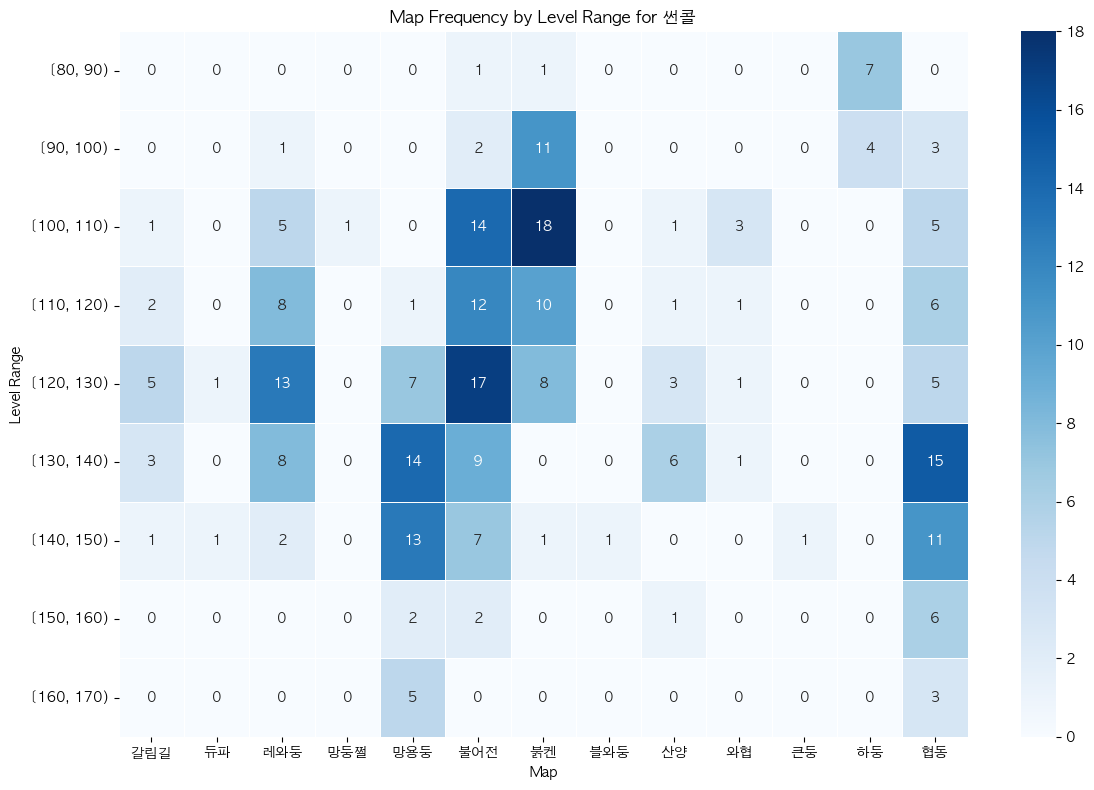

In [368]:
def plot_map_frequency_by_level_range(df, job_name):
    """
    Creates a heatmap showing map usage frequency for a specific job across level ranges.
    """
    # Filter for the selected job
    job_df = df[df['job'] == job_name]
    job_df['level_bin'] = pd.cut(job_df['level'], bins=range(80, 201, 10), right=False)

    # Count maps per level range
    map_frequency = pd.crosstab(job_df['level_bin'], job_df['map'])

    # Plot heatmap
    plt.figure(figsize=(12, 8))
    sns.heatmap(map_frequency, annot=True, fmt="d", cmap="Blues", linewidths=0.5)
    plt.title(f"Map Frequency by Level Range for {job_name}")
    plt.xlabel("Map")
    plt.ylabel("Level Range")
    plt.tight_layout()
    plt.show()

# Usage
plot_map_frequency_by_level_range(df, "썬콜")


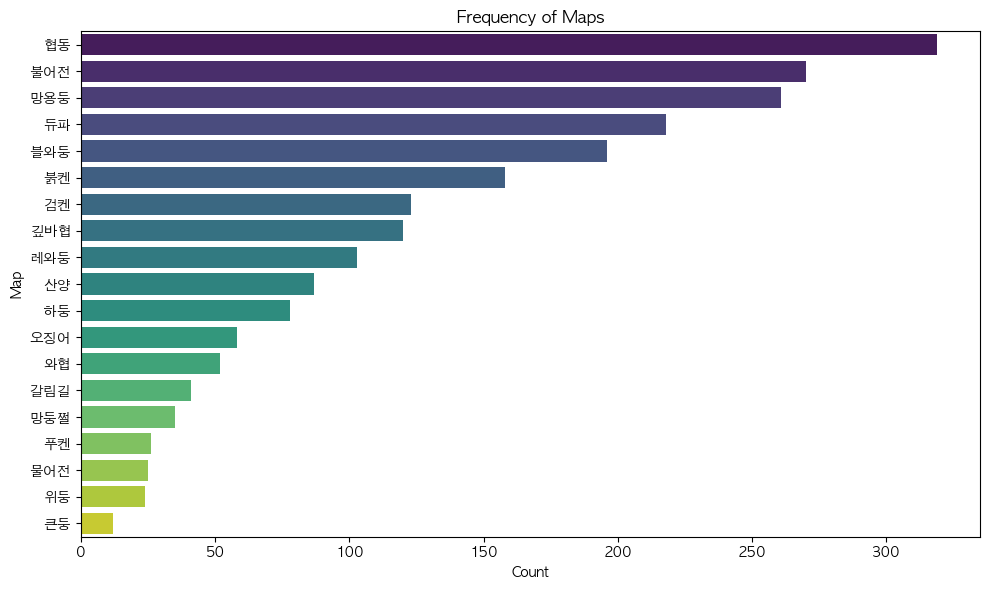

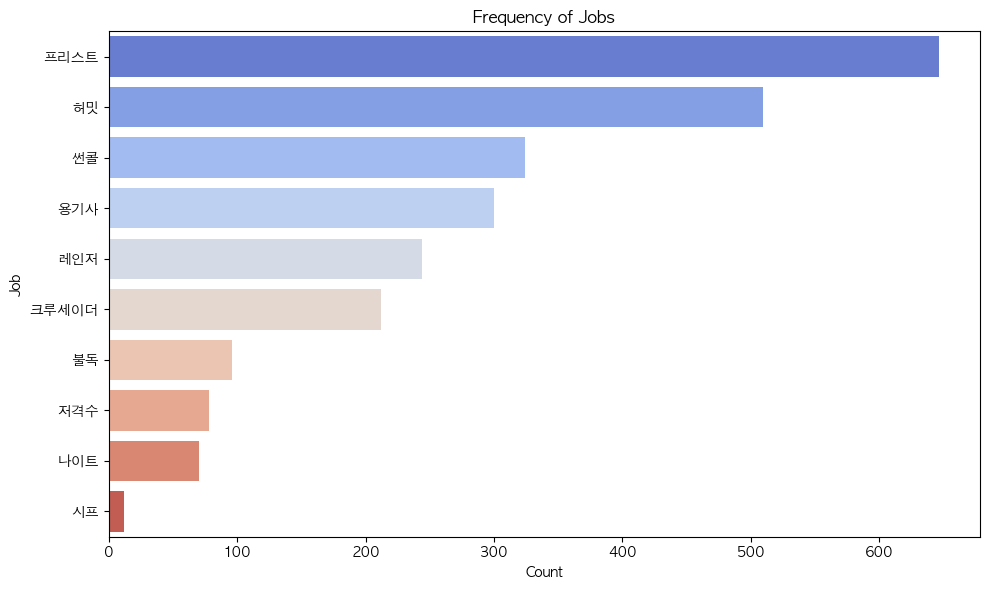

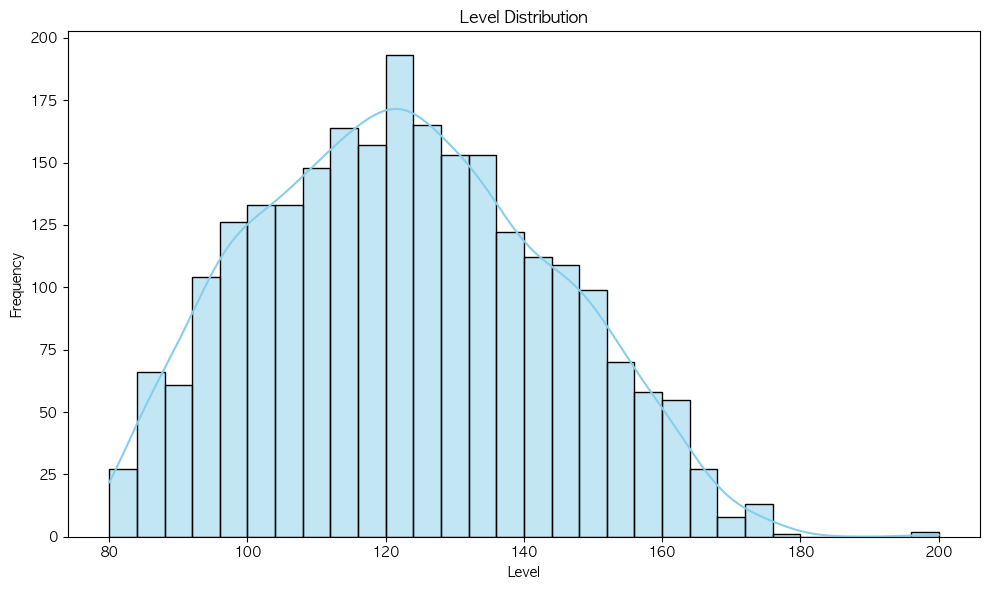

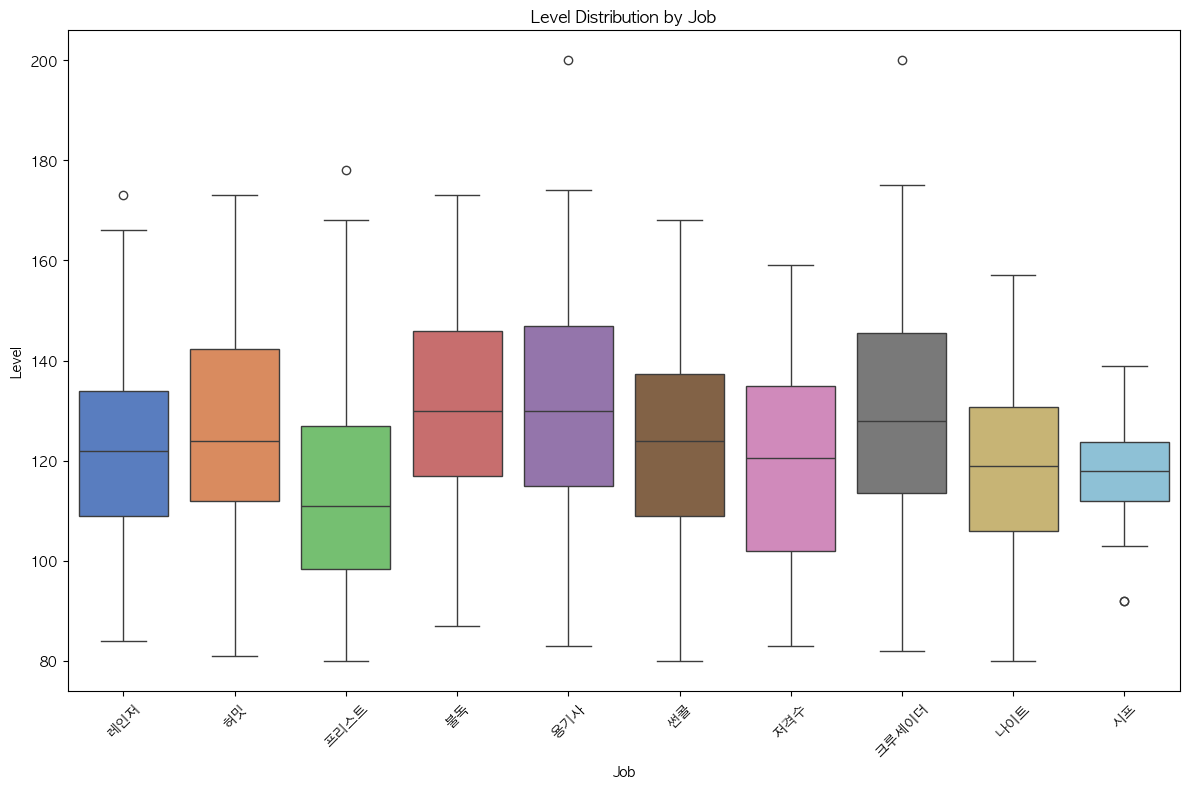

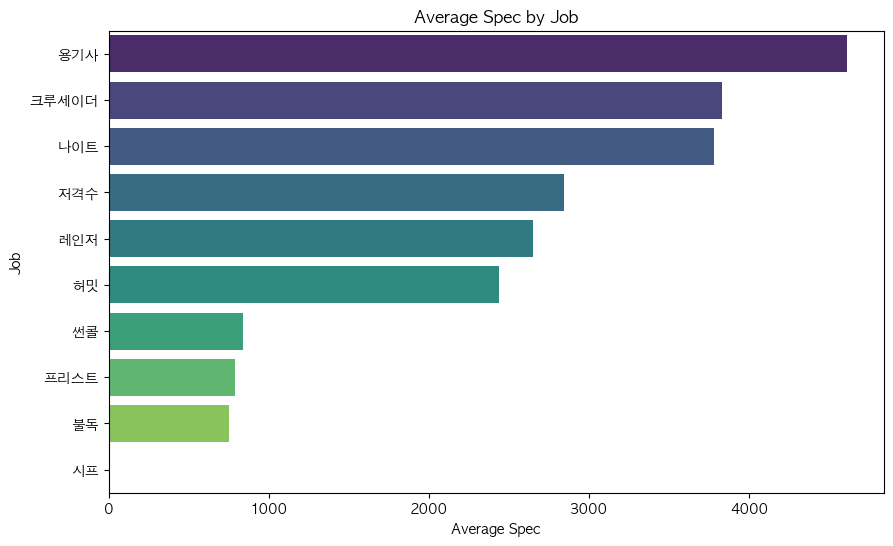

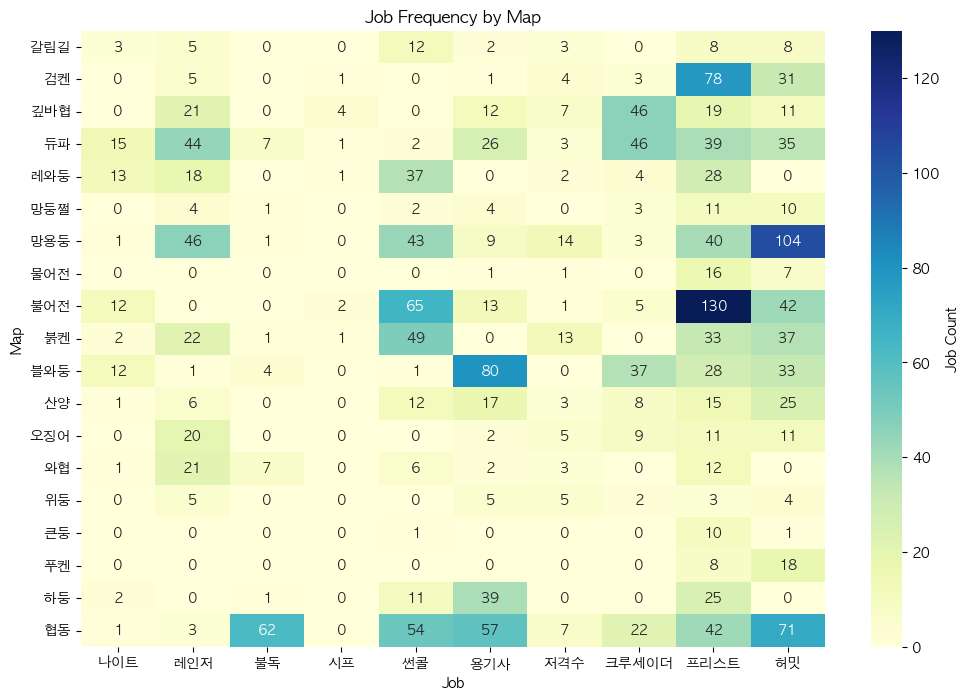

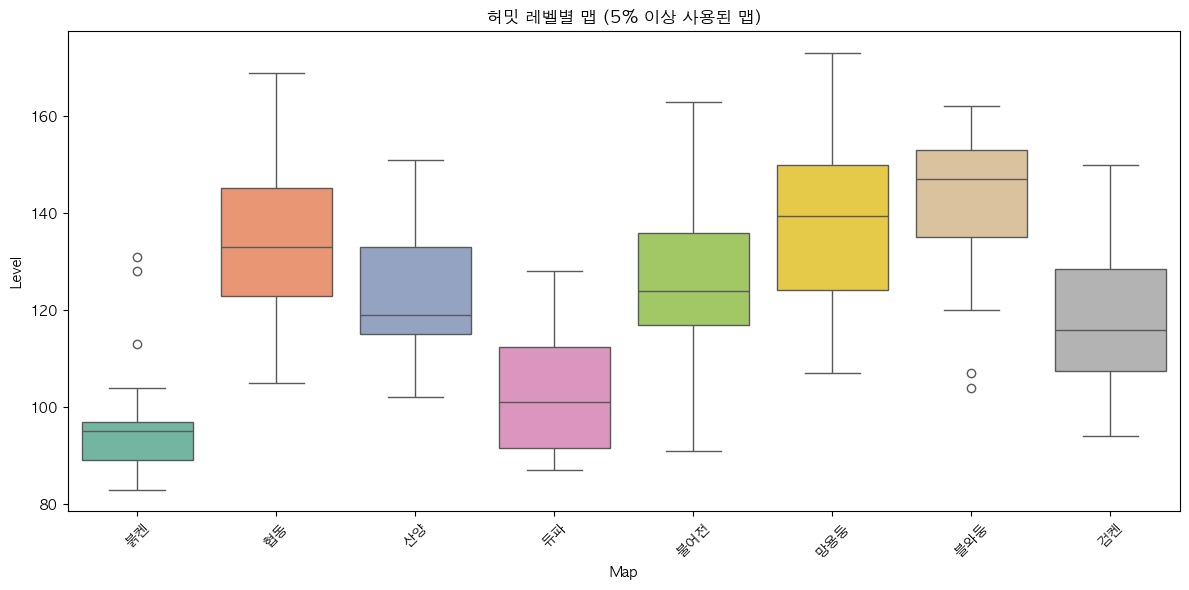

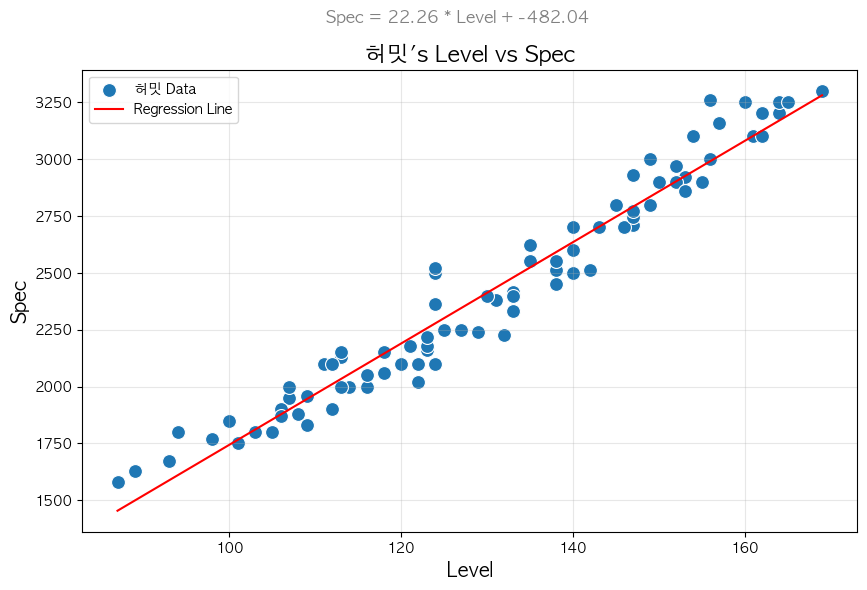

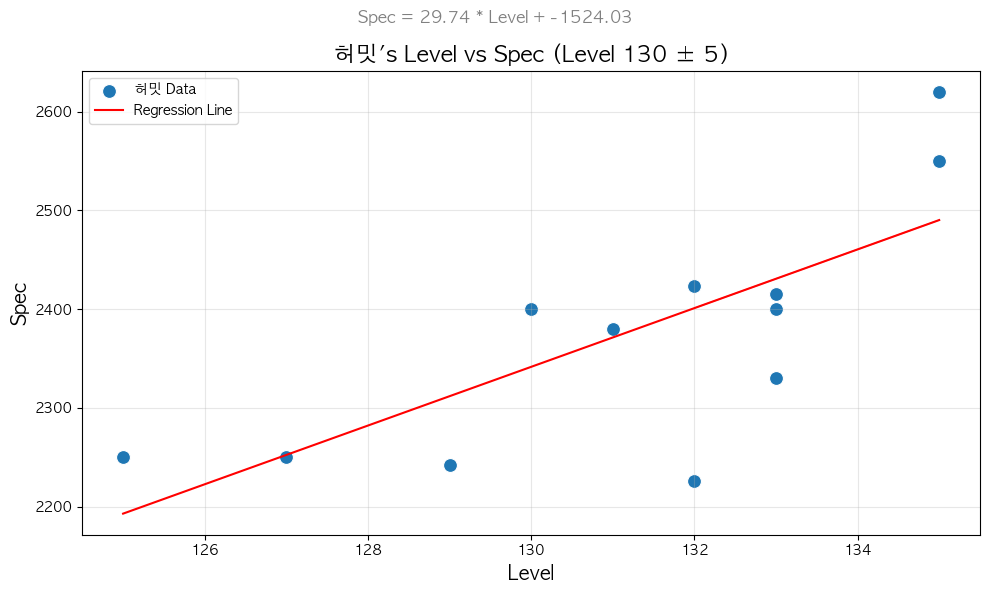

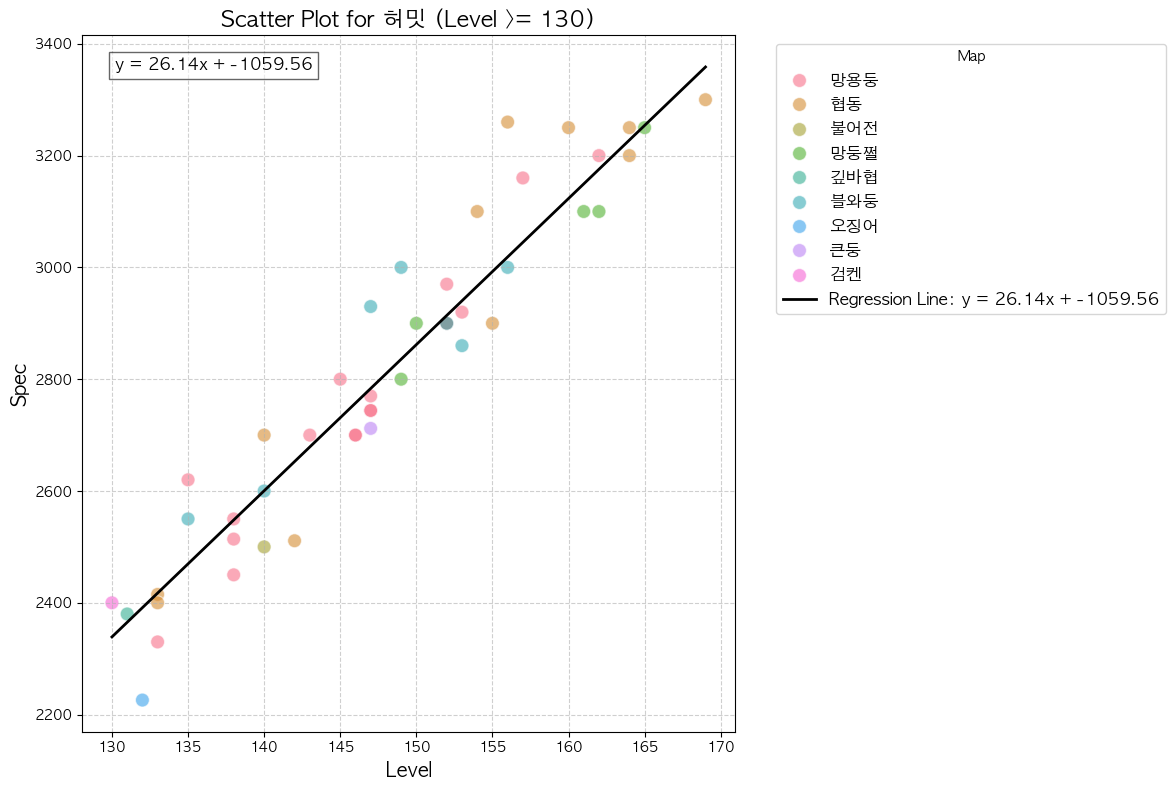

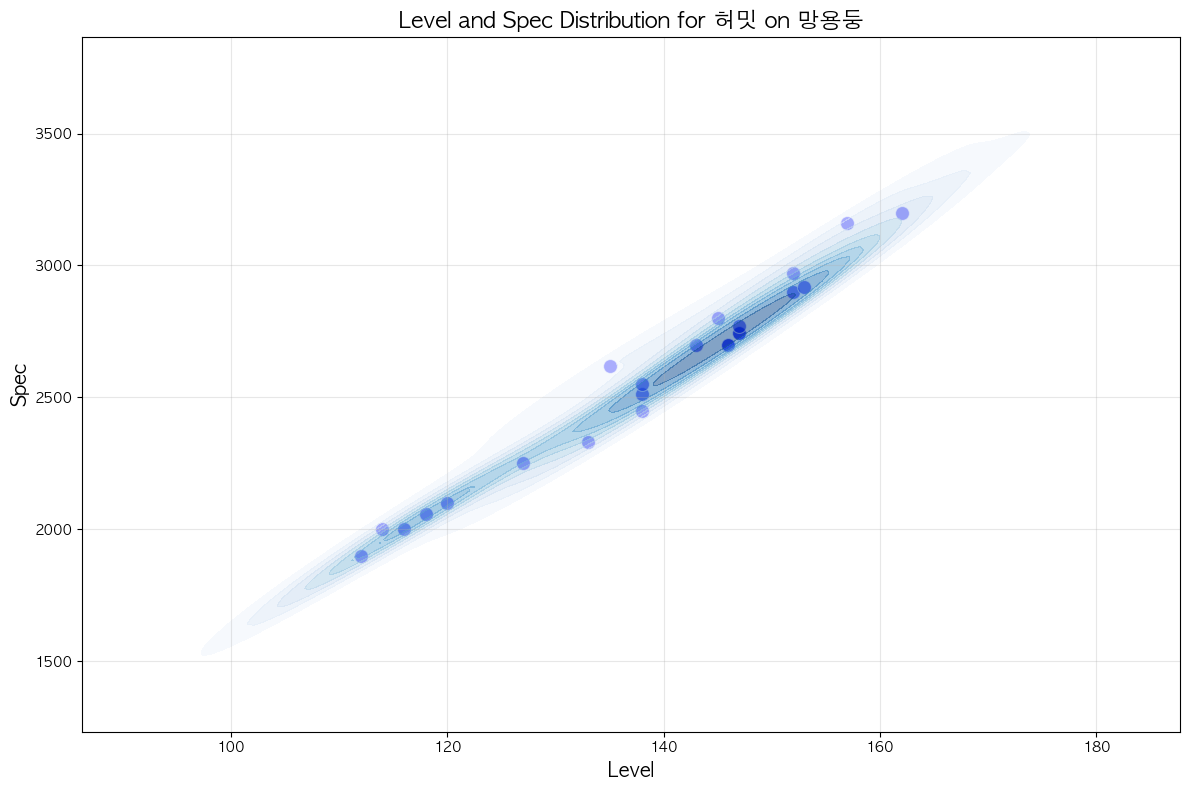

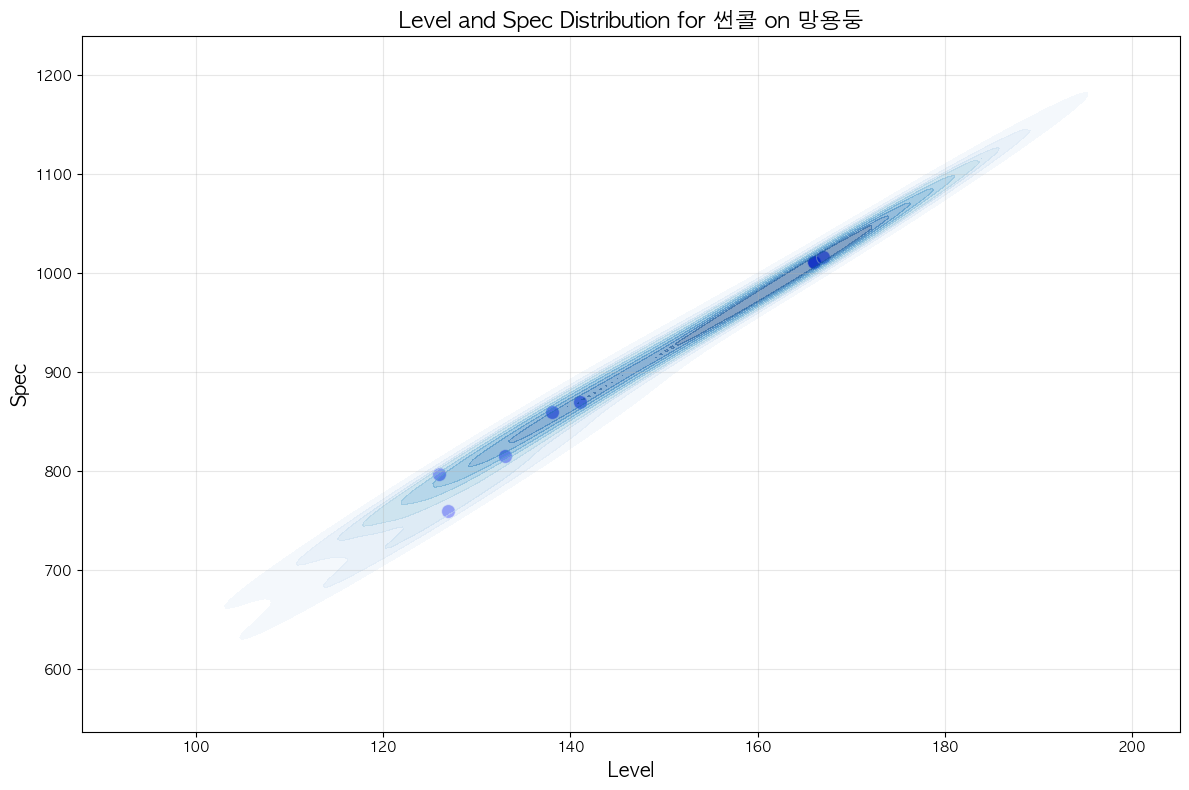

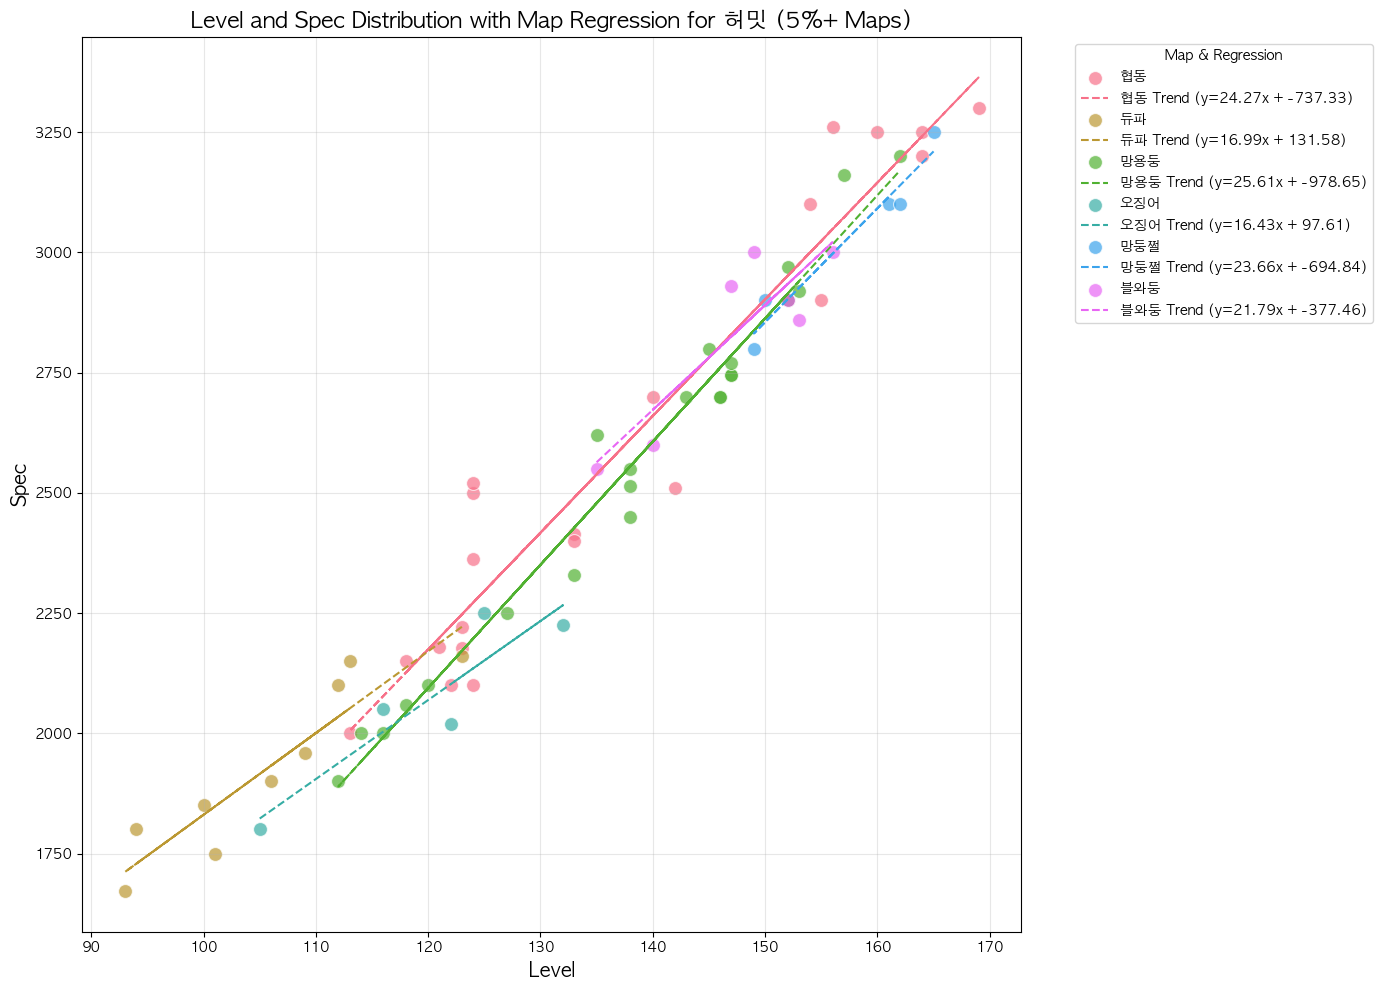

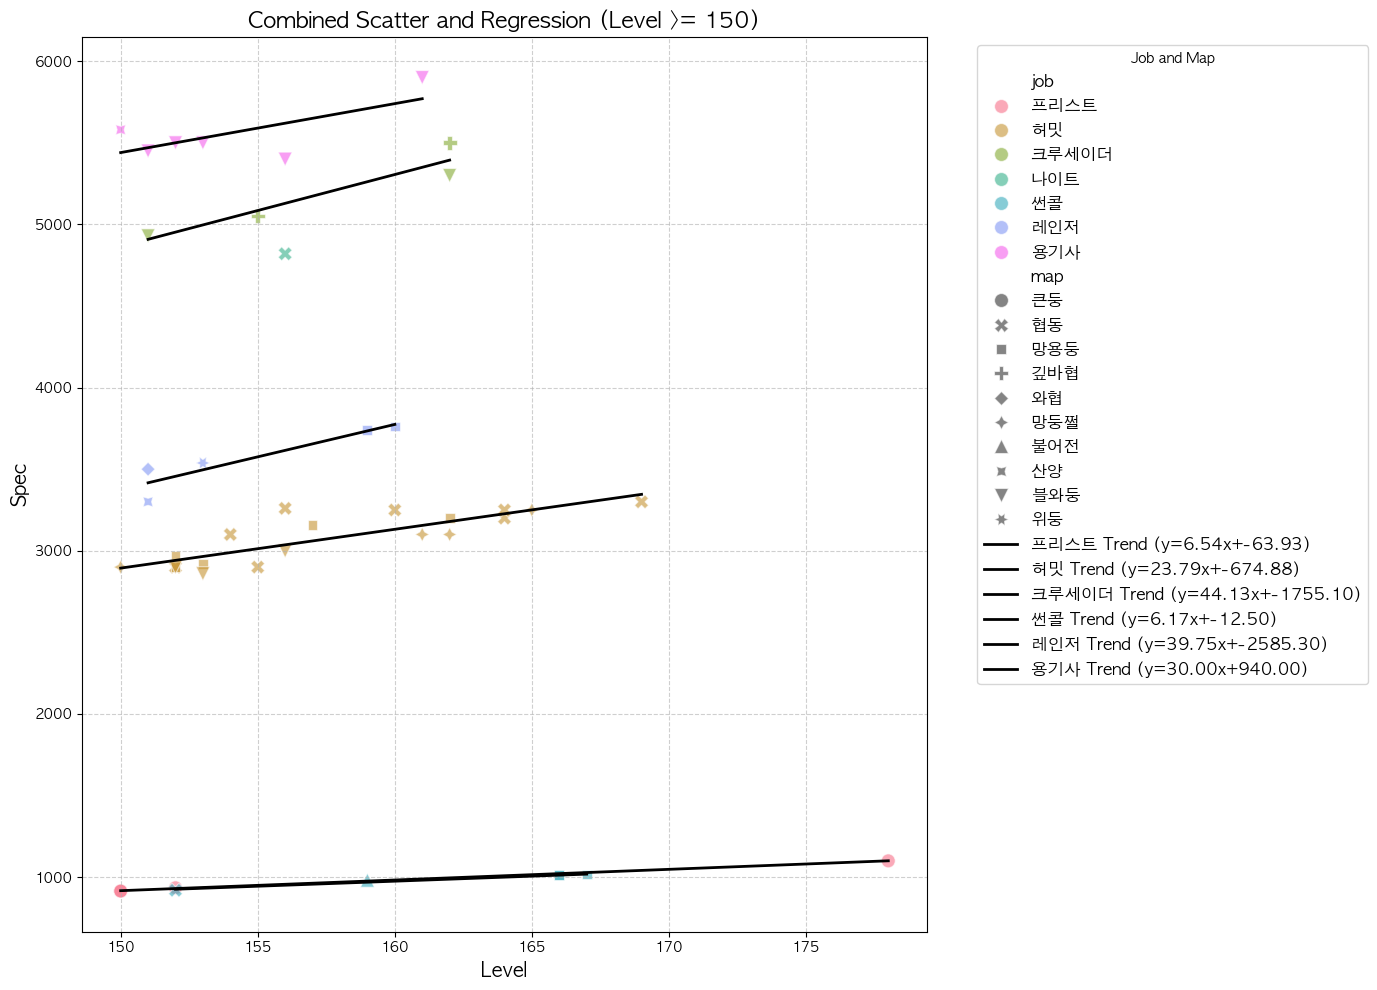

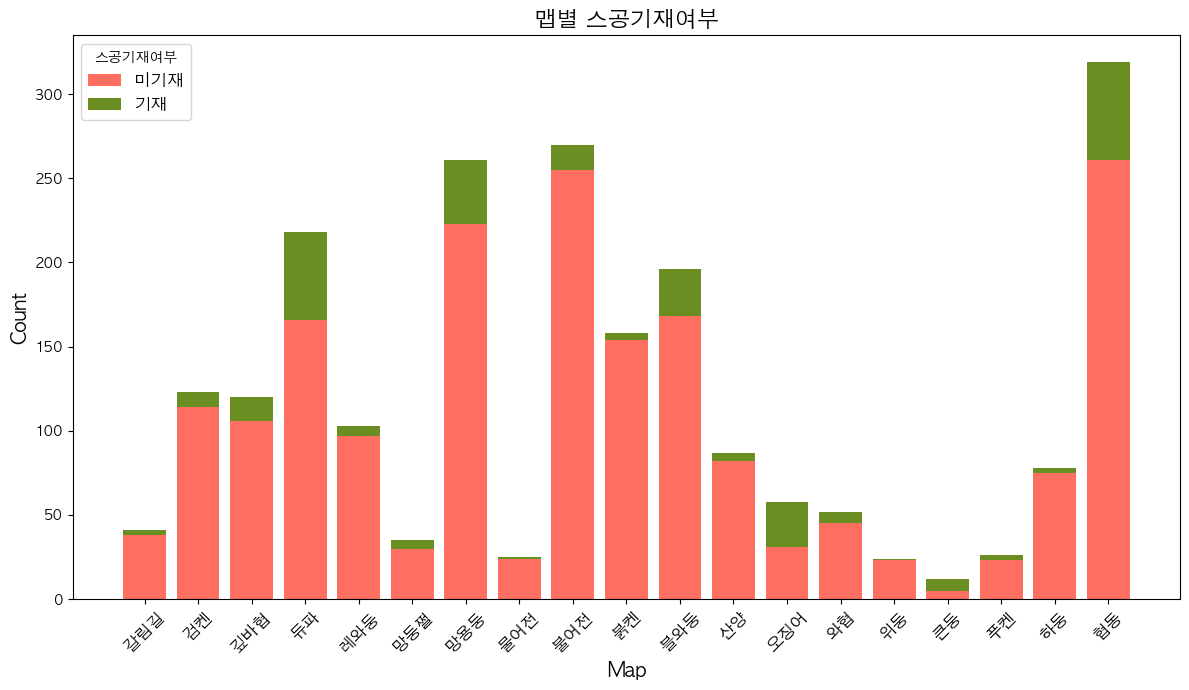

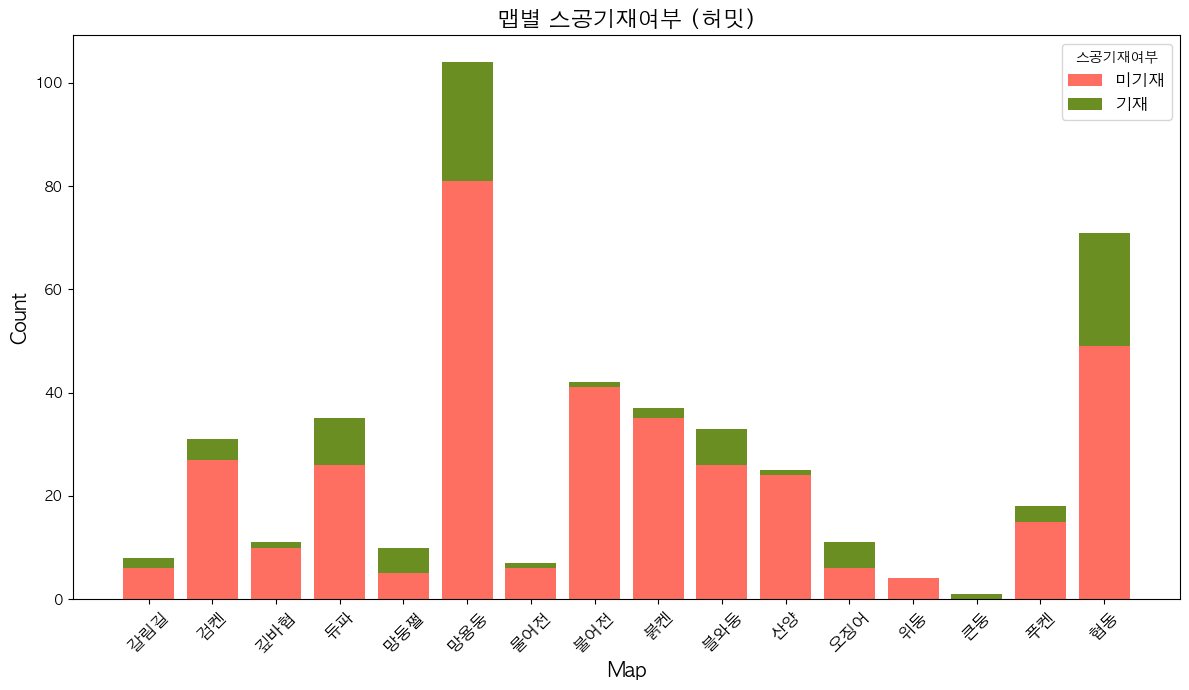

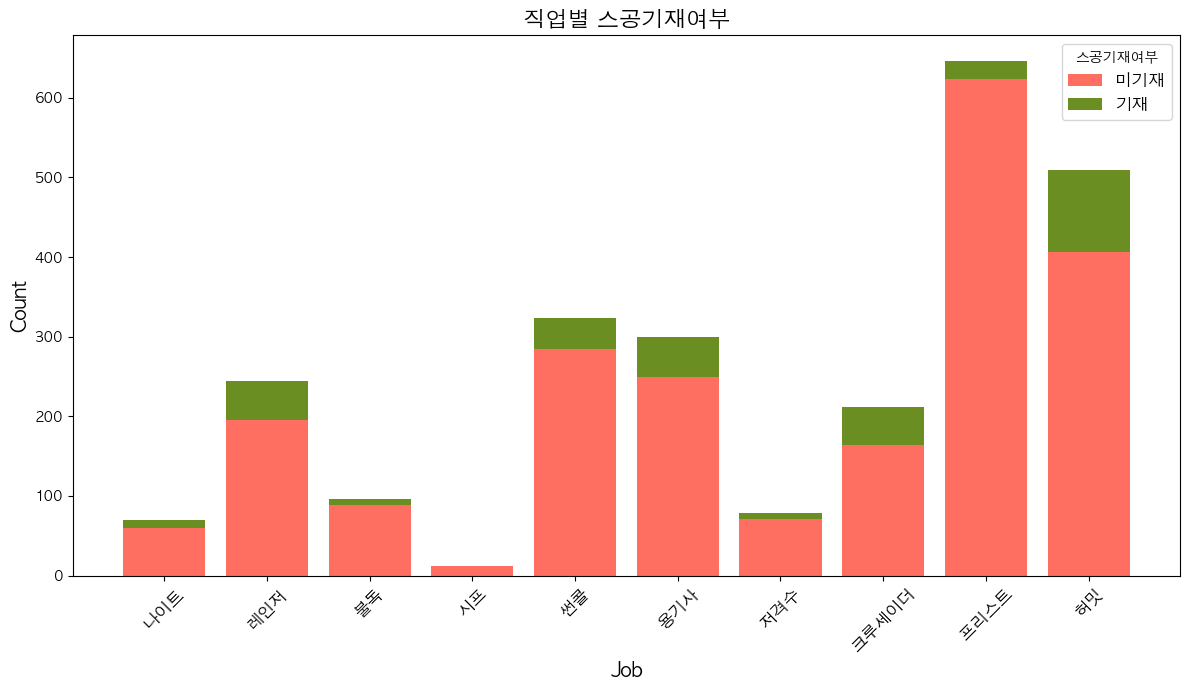

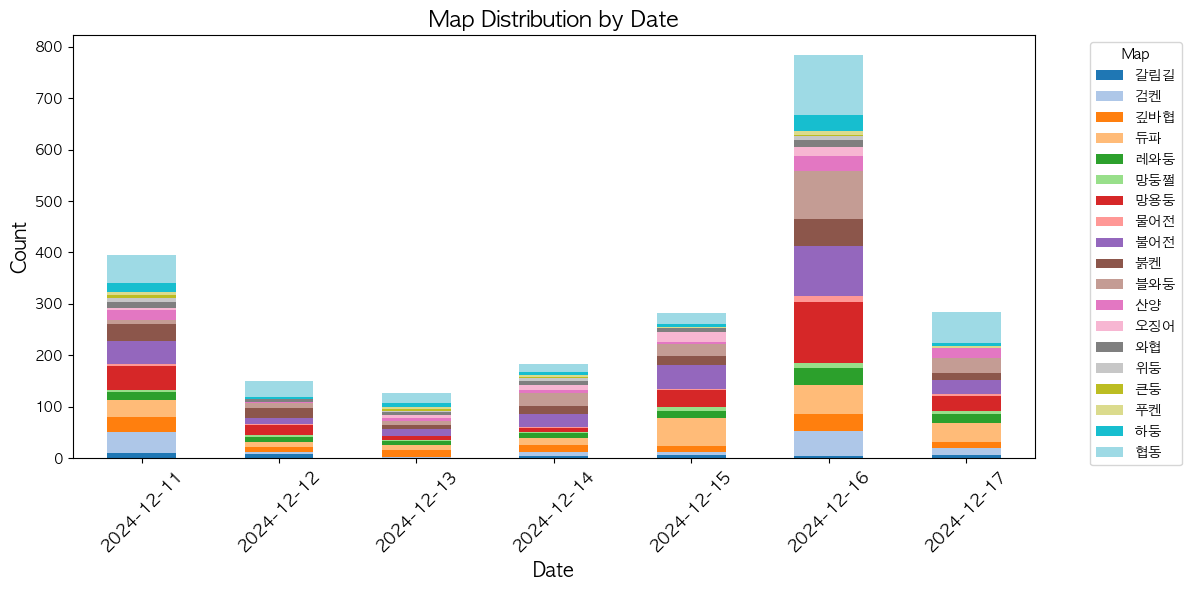

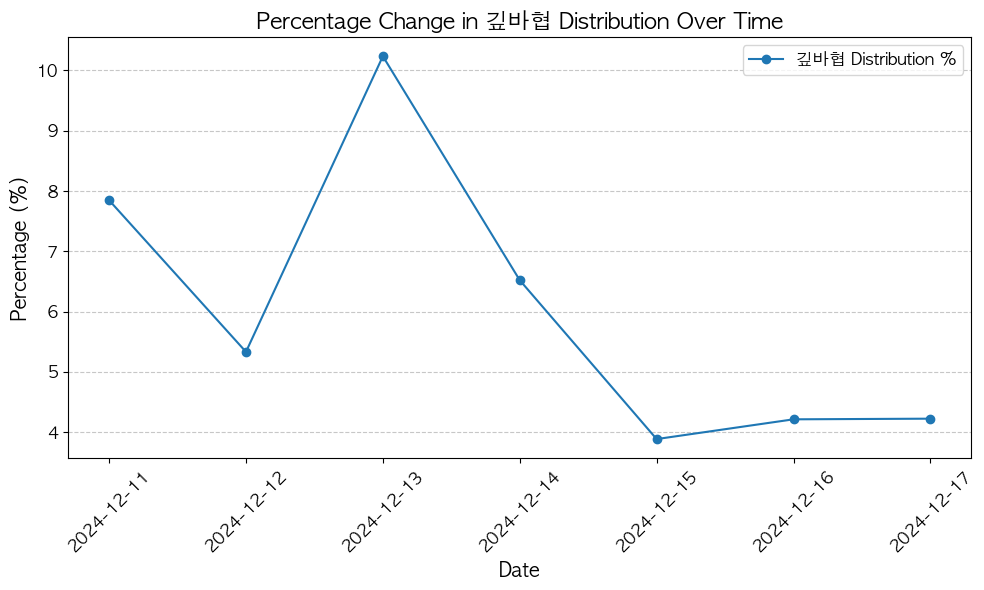

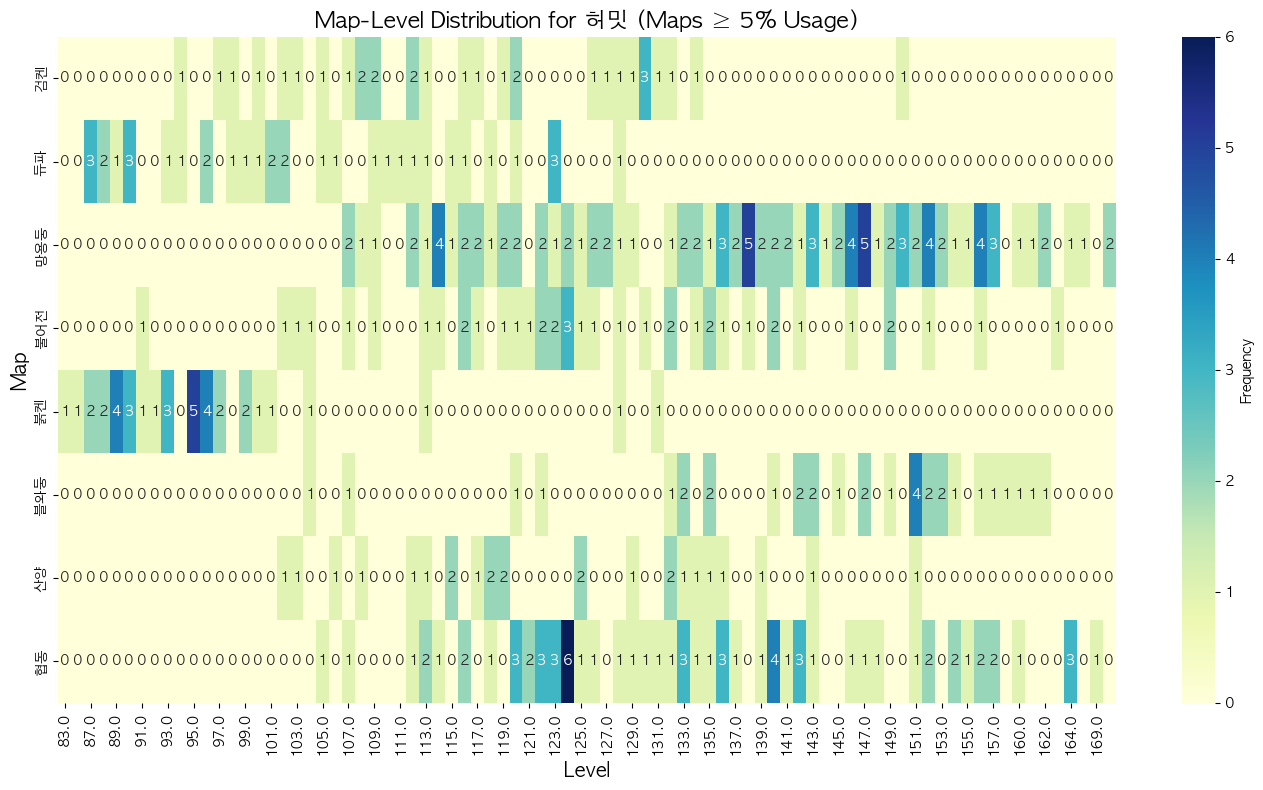

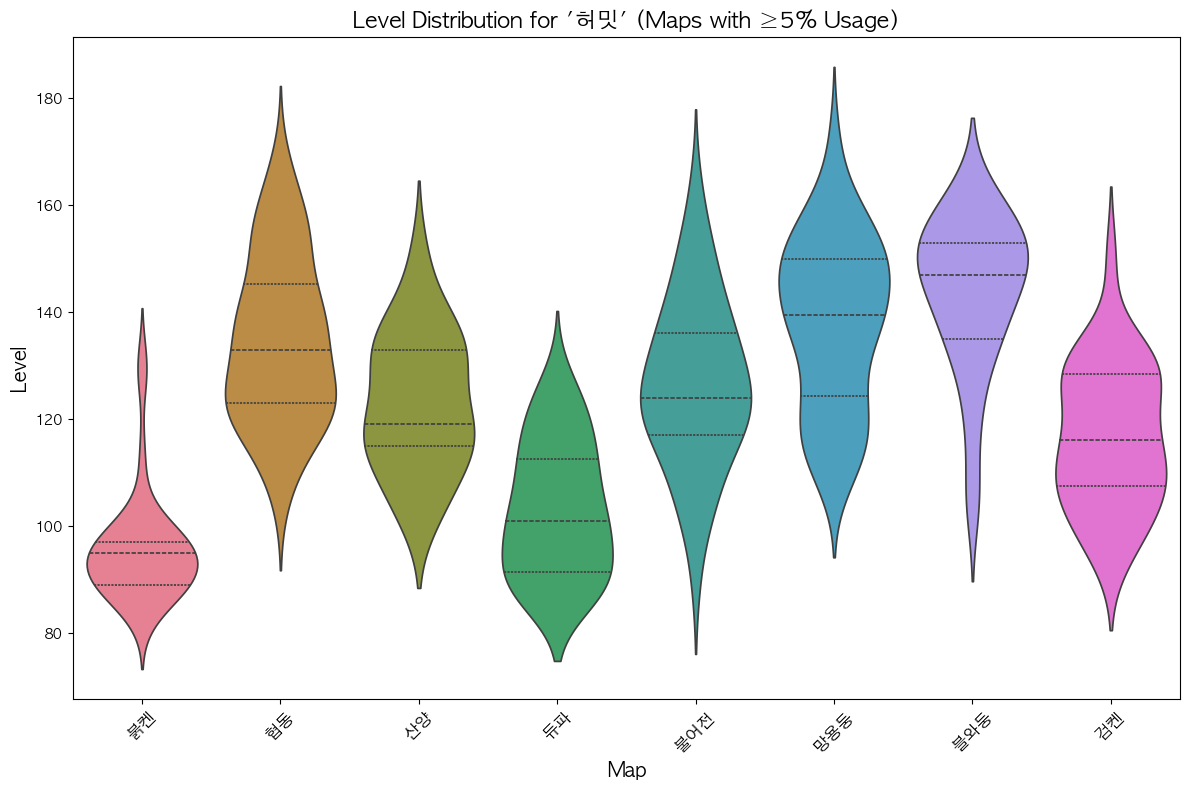

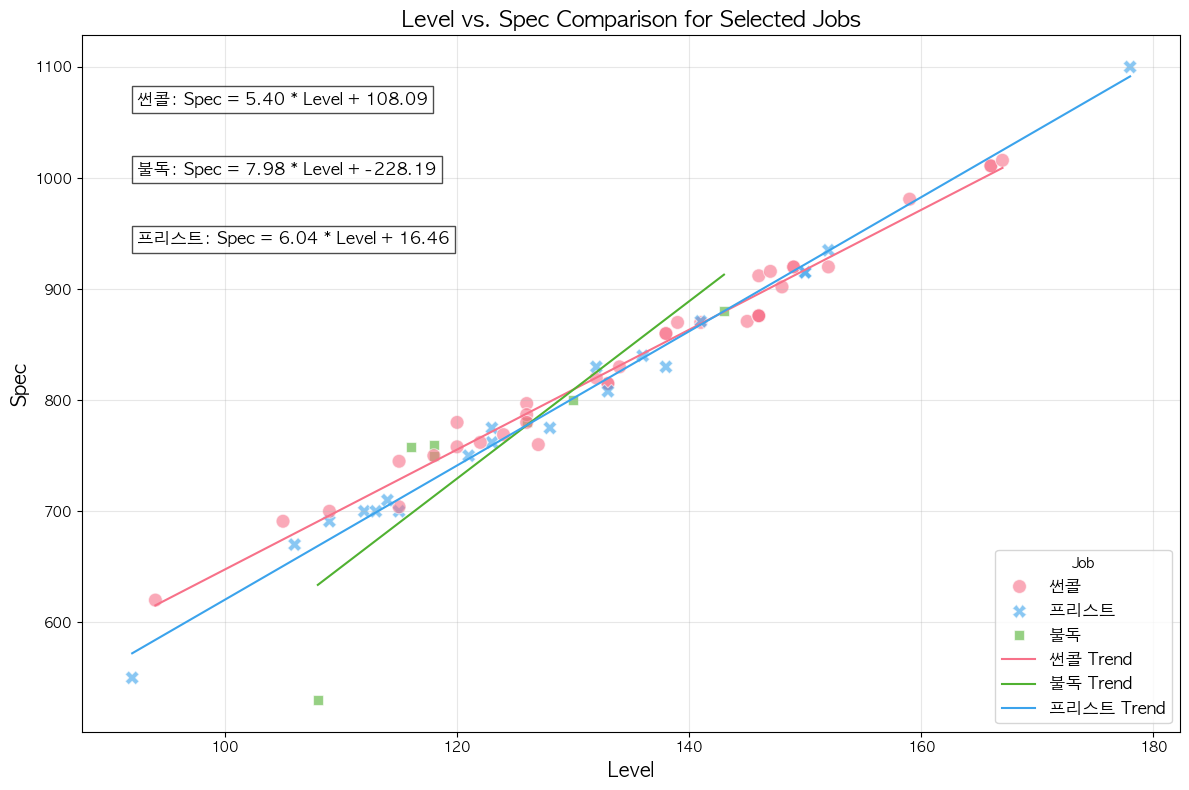

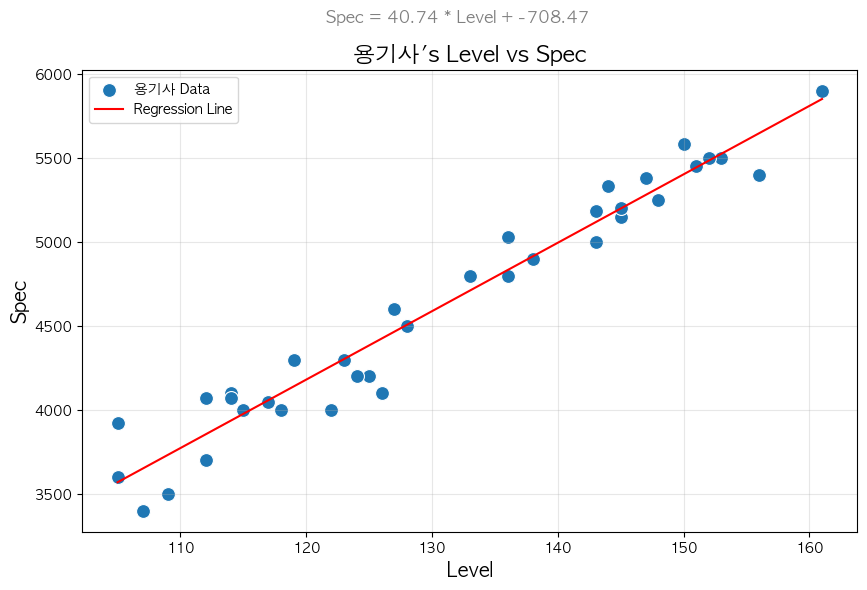

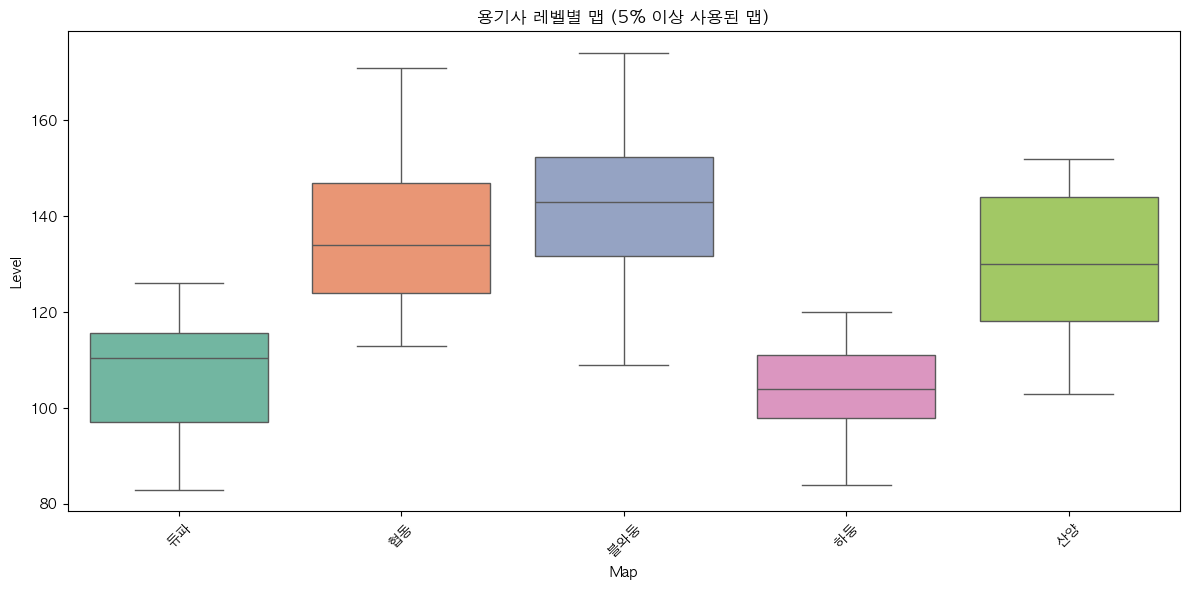

In [365]:
map_dist(df)
job_dist(df)
level_dist(df)
level_dist_by_job(df)
average_spec_by_job(processed_df)
plot_job_frequency_by_map(df)

plot_level_by_map_by_job(df, "허밋")
plot_level_spec_with_regression(processed_df, "허밋")
plot_level_spec_with_regression_by_level(df, "허밋", 130)
plot_scatter_by_job(df, "허밋", 130)
plot_level_spec_distribution_of_job_and_map(df, "망용둥", "허밋")
plot_level_spec_distribution_of_job_and_map(df, "망용둥", "썬콜")
plot_level_spec_distribution_of_job(df, "허밋")

plot_combined_scatter_with_regression_by_level(processed_df, 150)
visualize_spec_validity_by_map(df)
visualize_spec_validity_by_map(df, "허밋")
visualize_spec_validity_by_job(df)
visualize_map_distribution_by_date(df)
visualize_map_percentage_change(df, "깊바협")
plot_map_level_heatmap_for_job(df, "허밋")
plot_level_distribution_by_job_and_map(df, "허밋")

visualize_level_spec_comparison(processed_df, ['썬콜', '불독', '프리스트'])

plot_level_spec_with_regression(processed_df, "용기사")
plot_level_by_map_by_job(df, "용기사")

In [366]:
def print_high_level_data(df, threshold=150):
    high_level_data = df[df["level"] >= threshold]
    if high_level_data.empty:
        print(f"No data found where level is {threshold} or higher.")
    else:
        print(f"Data where level is {threshold} or higher:")
        print(high_level_data)

# Example usage
print_high_level_data(processed_df, threshold=160)

Data where level is 160 or higher:
     party_id      time  level    job  spec  map        date  valid  \
39         24   오후 1:13    164     허밋  3200   협동  2024-12-11   True   
45         75   오후 1:16    162  크루세이더  5500  깊바협  2024-12-11   True   
52        169   오후 1:34    164     허밋  3250   협동  2024-12-11   True   
53        181   오후 1:35    166     썬콜  1011  망용둥  2024-12-11   True   
55        285   오후 1:37    178   프리스트  1100   큰둥  2024-12-11   True   
72          8   오후 3:47    166     썬콜  1011  망용둥  2024-12-15   True   
73          9   오후 3:47    161     허밋  3100  망둥쩔  2024-12-15   True   
136        99   오후 2:53    161    용기사  5900  블와둥  2024-12-14   True   
159       142  오전 12:43    160     허밋  3250   협동  2024-12-16   True   
163       151  오전 12:44    169     허밋  3300   협동  2024-12-16   True   
173       200  오전 12:46    162     허밋  3100  망둥쩔  2024-12-16   True   
199       457   오전 1:19    160    레인저  3761  망용둥  2024-12-16   True   
241       962   오전 2:54    162  크루세이더  530

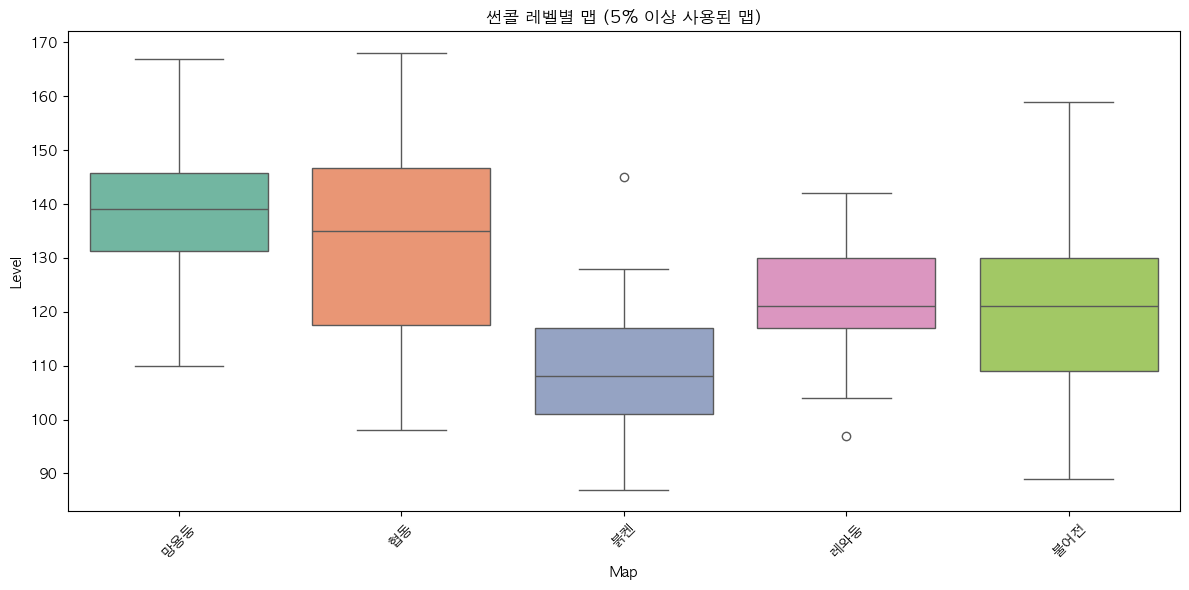

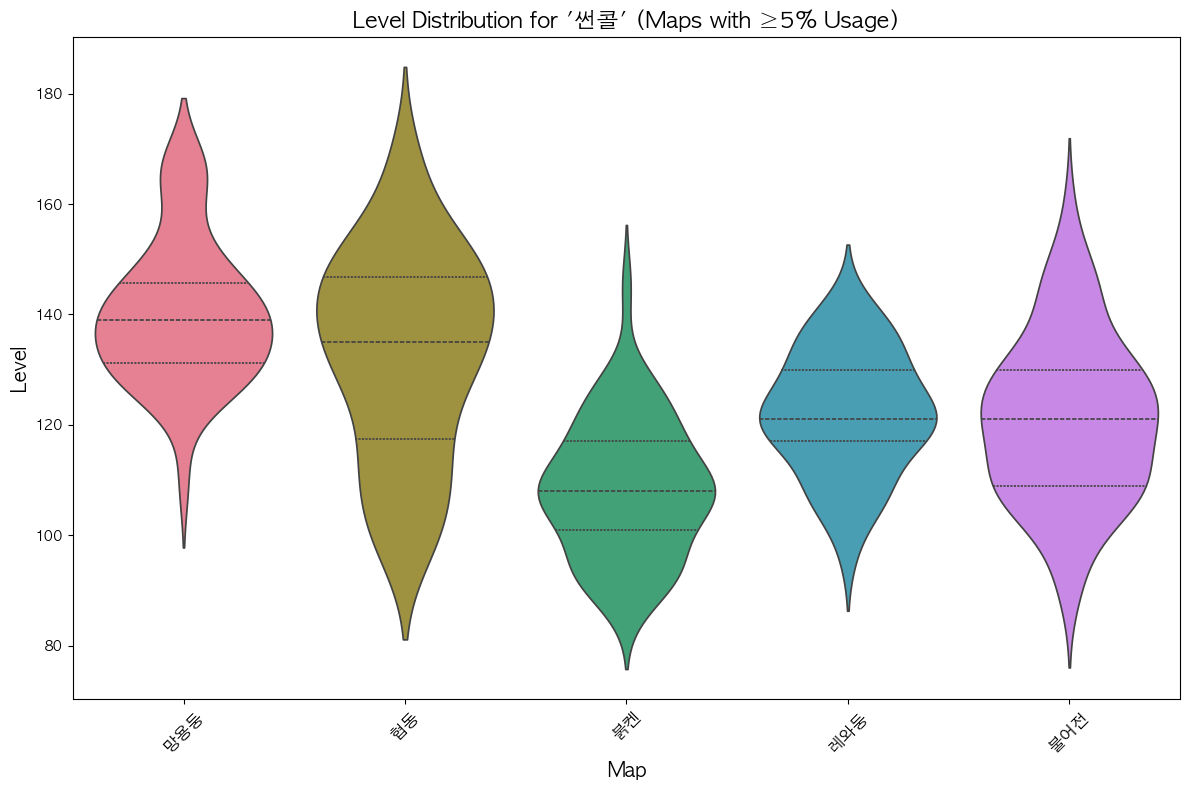

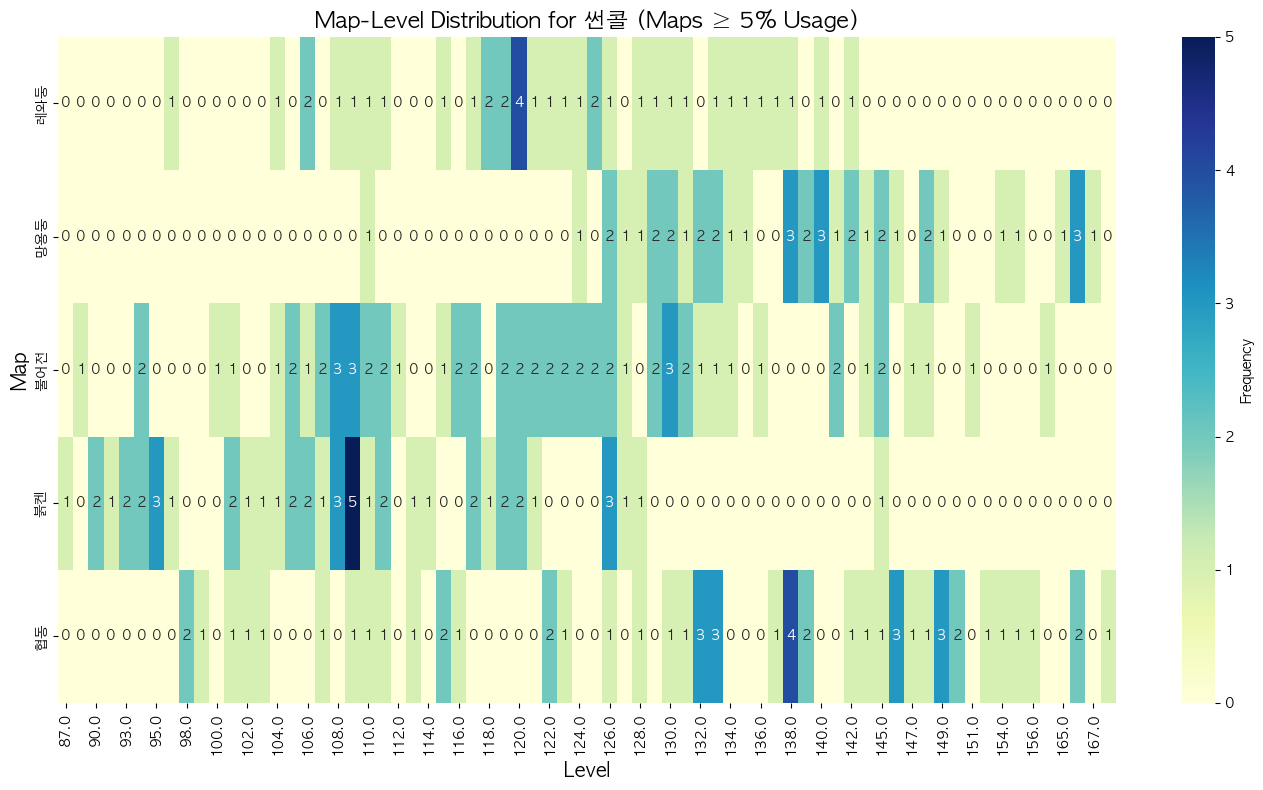

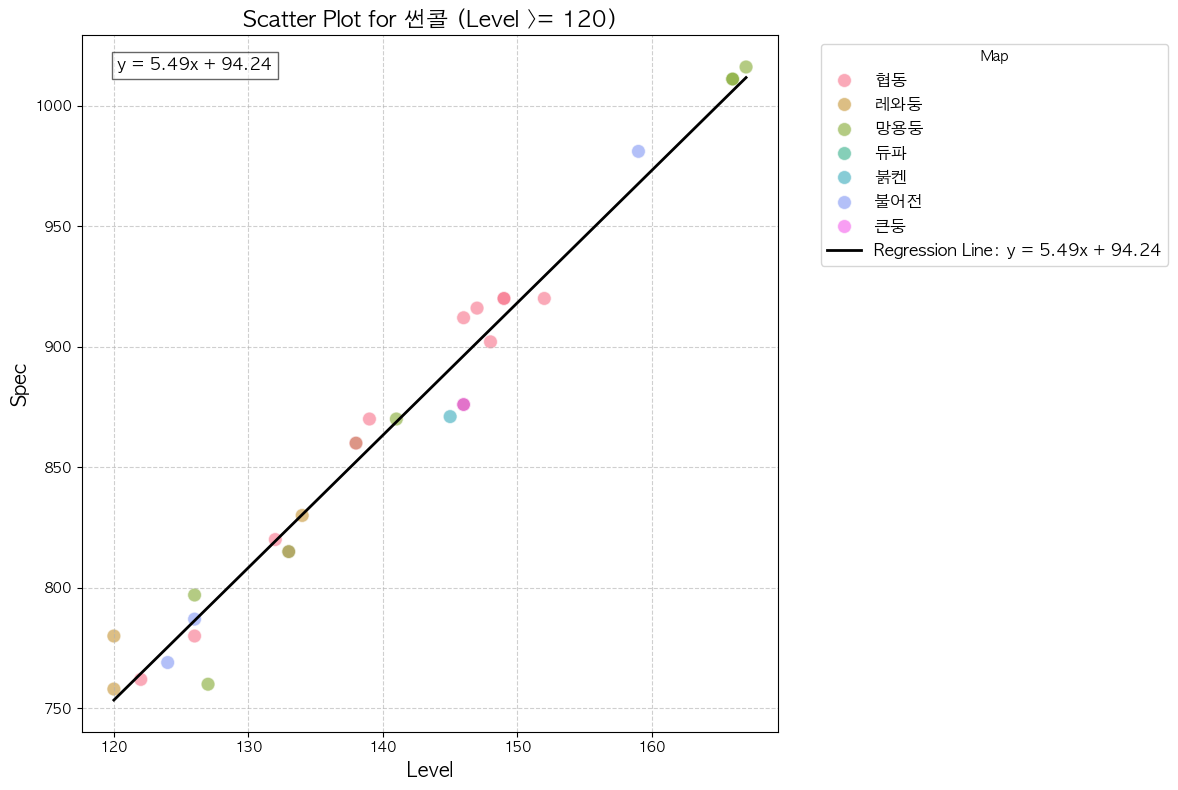

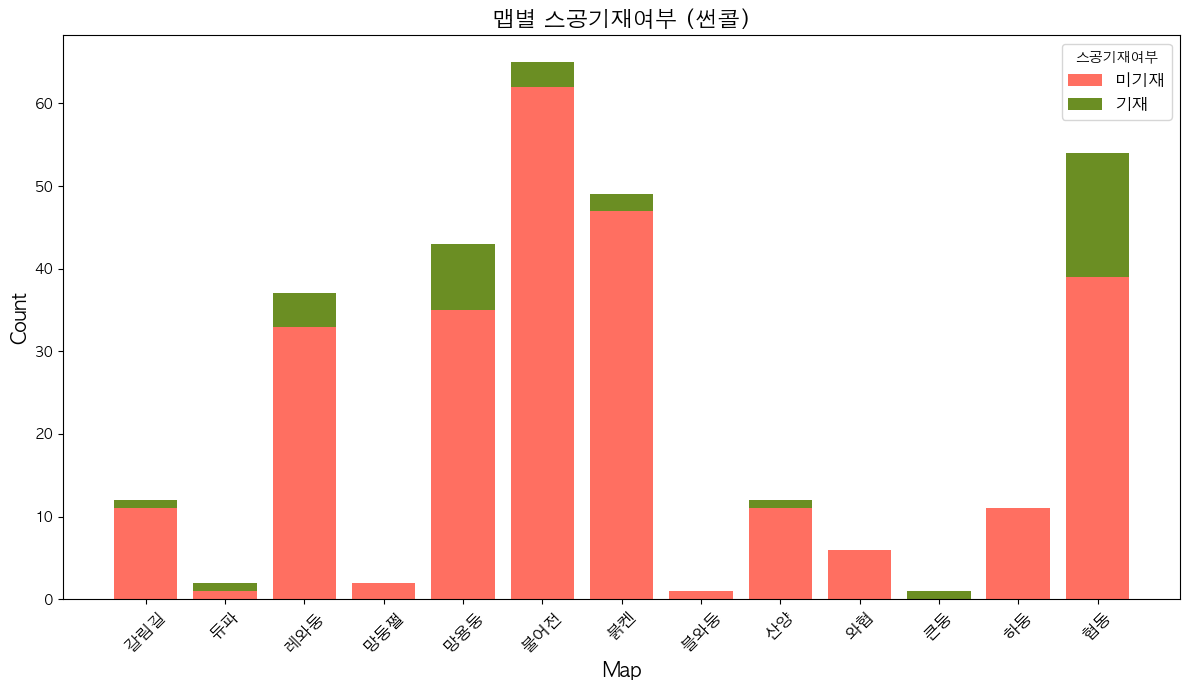

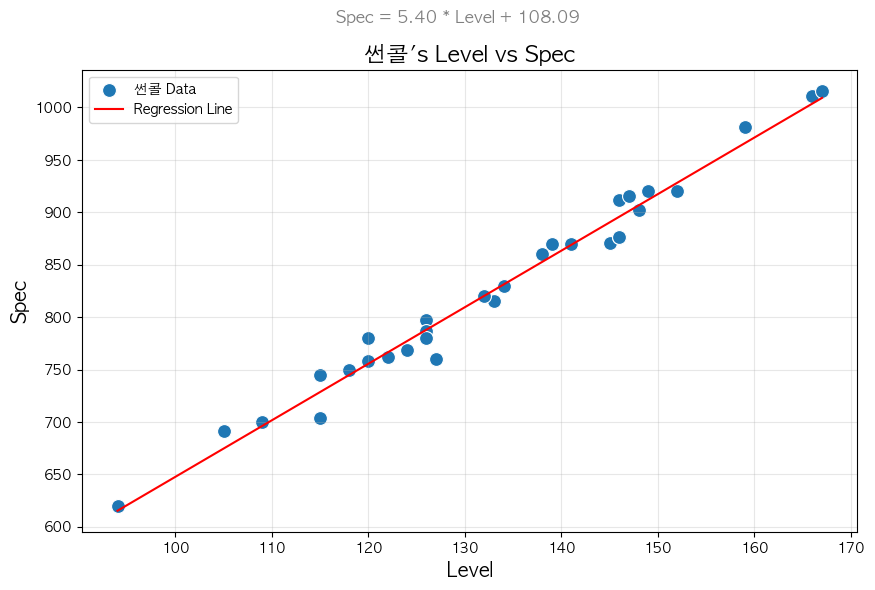

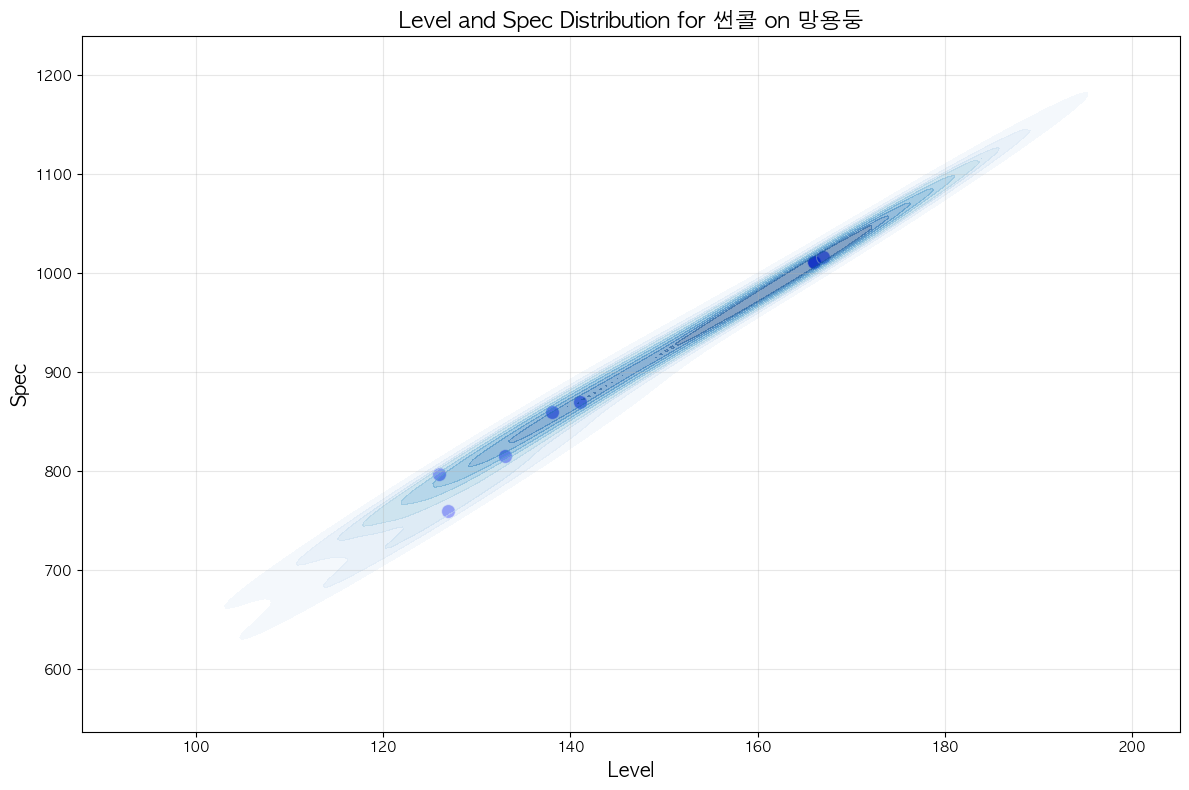

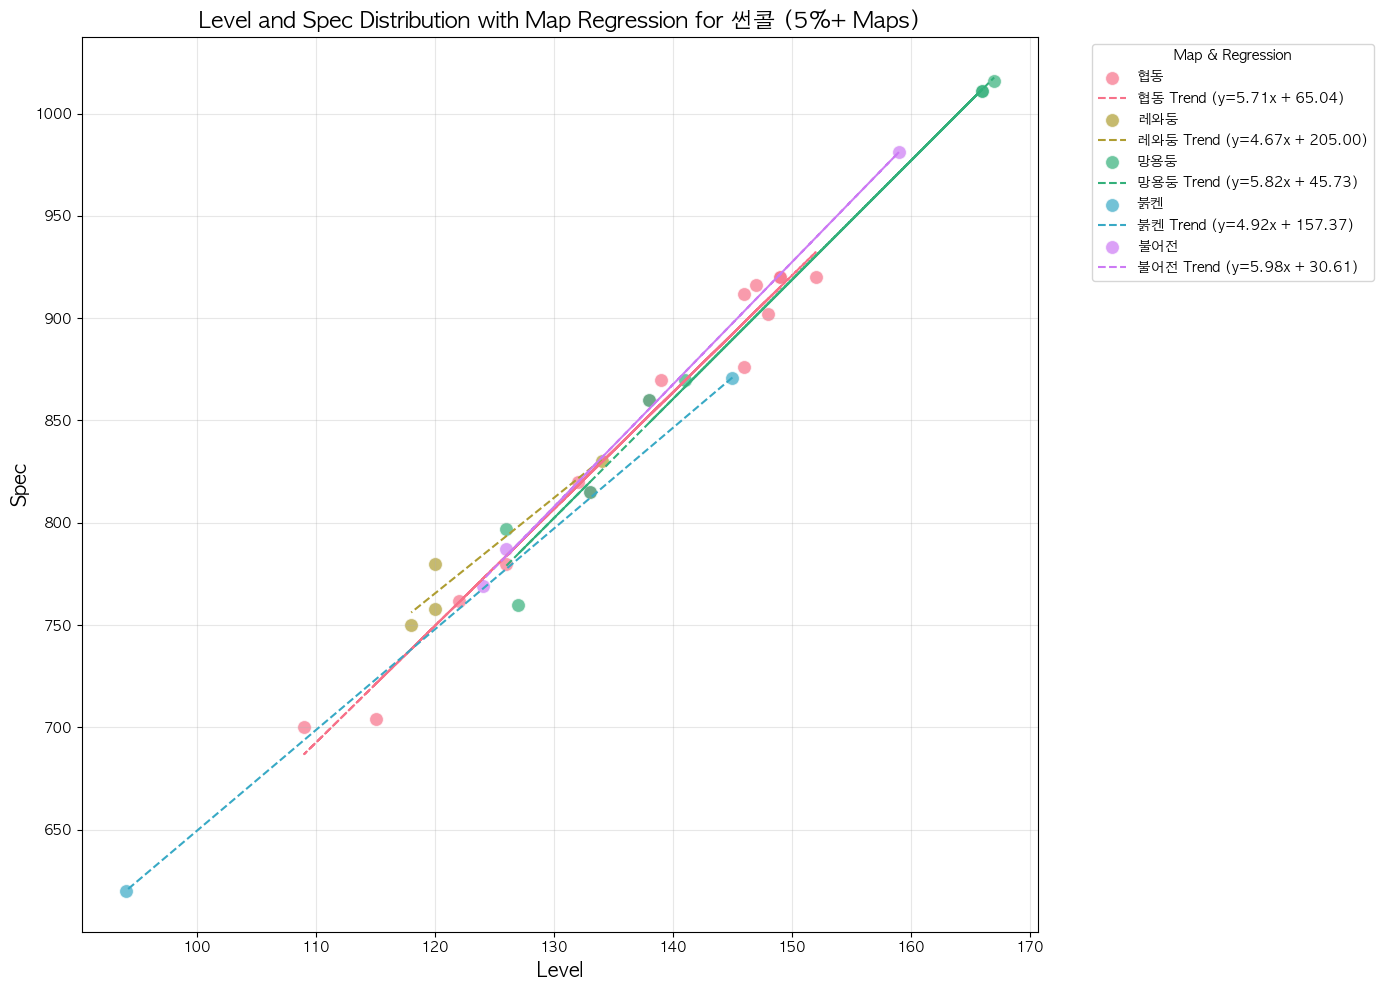

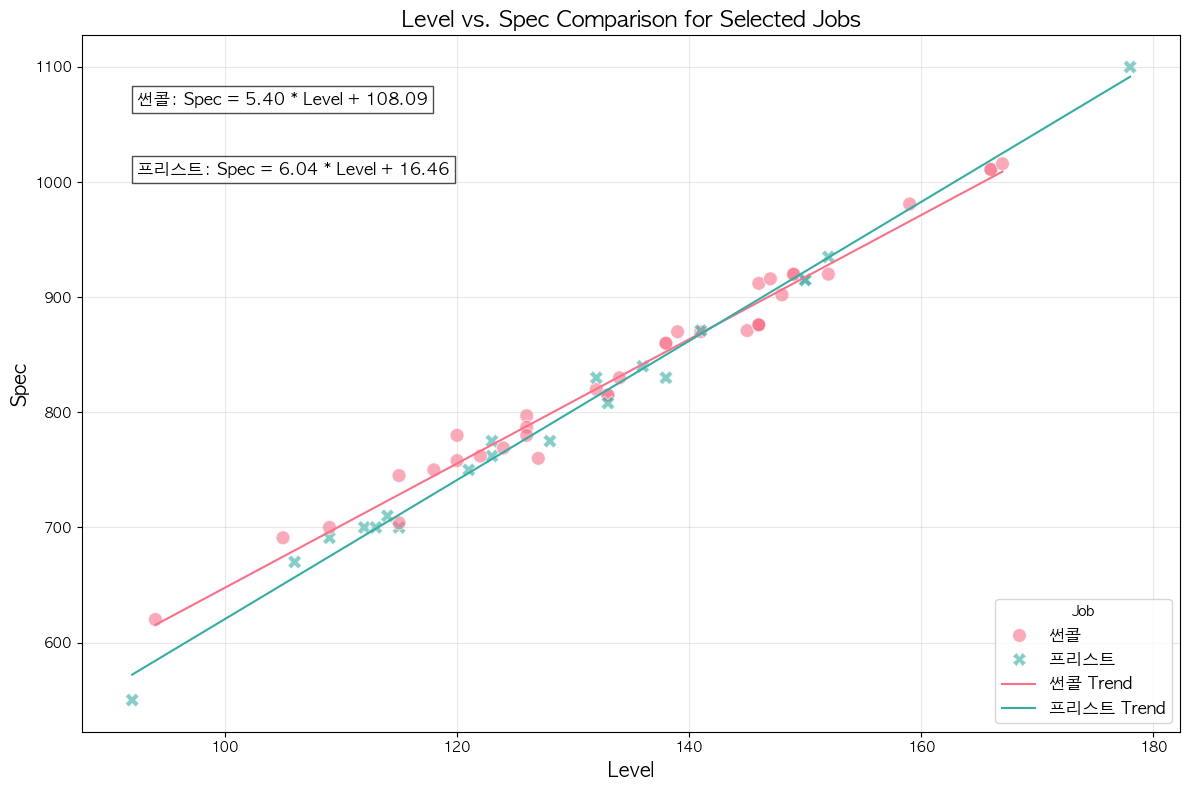

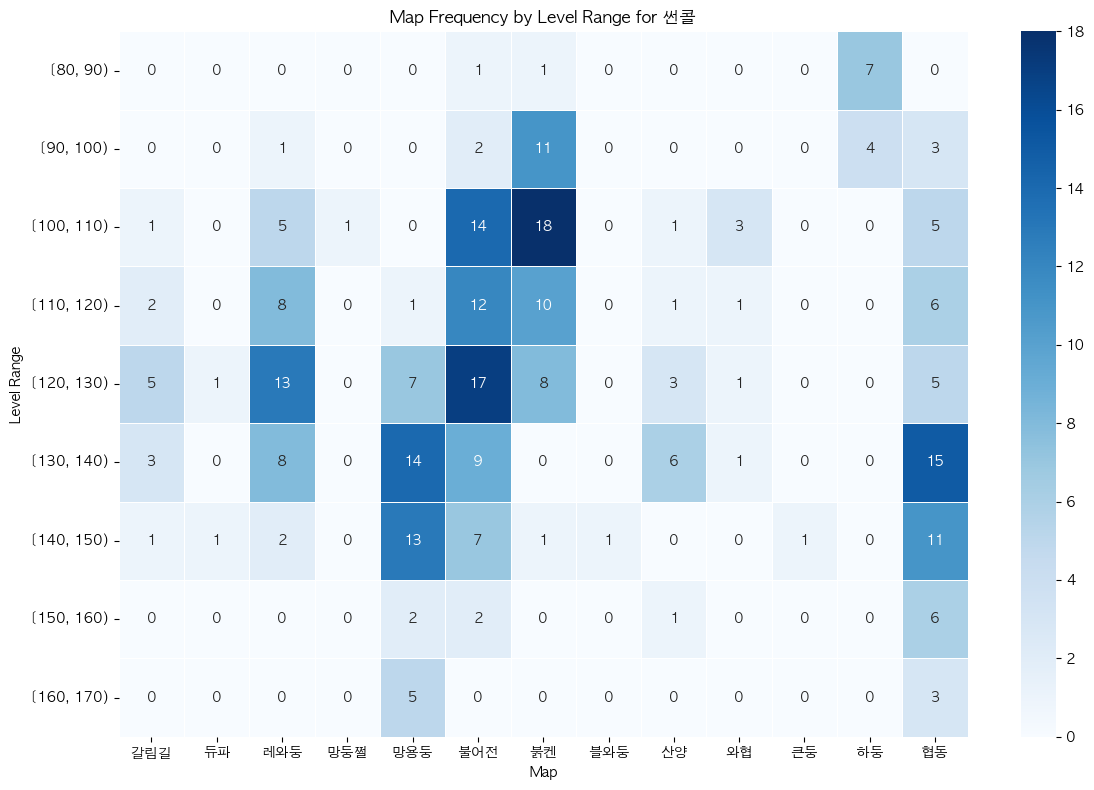

In [369]:
#썬콜
plot_level_by_map_by_job(df, "썬콜")
plot_level_distribution_by_job_and_map(df, "썬콜")
plot_map_level_heatmap_for_job(df, "썬콜")
plot_scatter_by_job(df, "썬콜", 120)
#spec
visualize_spec_validity_by_map(df, "썬콜")
plot_level_spec_with_regression(processed_df, "썬콜")
plot_level_spec_distribution_of_job_and_map(df, "망용둥", "썬콜")
plot_level_spec_distribution_of_job(df, "썬콜")
visualize_level_spec_comparison(processed_df, ['썬콜', '프리스트'])
plot_map_frequency_by_level_range(df, '썬콜')

In [340]:
#by Willkie